# milner video proj

In [1]:
# Import all the things.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Config
XLABEL = 'Time (s)'
YLABEL = 'Speed (m/s)'

In [3]:
RESULTS = []
STDEVS = []

## Helper funcs

In [4]:
def get_crests(df, wave_filter=None, use_troughs=False):
    if wave_filter is not None:
        df = wave_filter.apply_x_filter(df)
    points = df[YLABEL].tolist() # Store a list of the points from the sample.
    crests = []
    ends_of_cycles = []

    for index, point in enumerate(points): # Go through each point one by one
        try:
            if point > 0 and points[index+1] < 0:
                ends_of_cycles.append(index)
        except IndexError:
            pass


    raw_cycles = [sl.tolist() for sl in np.split(points, ends_of_cycles)][:-1]
    cycles = [x for x in raw_cycles if x != []]
    for cycle in cycles:
        crests.append(max(cycle) if use_troughs is False else min(cycle))
    if wave_filter is not None:
        crests = wave_filter.apply_y_filter(crests)
    return crests

In [5]:
def big_scary_plot(smpls):
    fig = plt.figure(figsize=[18,6])

    for frame in smpls.keys():
        fr = smpls[frame]
        plt.plot(fr[XLABEL], fr[YLABEL])

    plt.legend(smpls.keys())
    plt.grid(visible=True)
    plt.show()

In [6]:
def plot_trial_dataframe(df, name=None, xlabel=None, ylabel=None, yerr=None, graph_type=None, use_index=None):
    df.plot(
        x=xlabel or XLABEL,
        y=ylabel or YLABEL,
        kind=graph_type or 'line',
        figsize=(24,6),
        grid=True,
        title=name,
        xlabel=xlabel or XLABEL,
        ylabel=ylabel or YLABEL,
        yerr=yerr or None,
        use_index=use_index or False
    )

In [7]:
def filter_points(crests_list):
    abs_cr = np.absolute(crests_list)
    filtered_cr = sorted(abs_cr, reverse=True)
    return filtered_cr[0:5]

## Main computation

In [8]:
def read_in_trials(tlabel):
    deg_samples = {}
    for trial in range(1, 11):
        trial_id = f"{tlabel}-t{trial}"
        csv_name = f"{trial_id}.csv"
        try:
            df = pd.read_csv(csv_name)
            df.drop(df[df[XLABEL] == '#NUM!'].index, inplace=True)
            df.drop(df[df[YLABEL] == '#NUM!'].index, inplace=True)
            df.drop(df[df['Frequency (Hz)'] == '#NUM!'].index, inplace=True)
            df[XLABEL] = pd.to_numeric(df[XLABEL])
            df[YLABEL] = pd.to_numeric(df[YLABEL])
            deg_samples[trial_id] = df
        except FileNotFoundError:
            print(f'File {csv_name} not found!')
    return deg_samples

In [9]:
def run_experimental_computation(sample_dict, wfs_table, label):
    avglist = []
    for tdf_key in sample_dict.keys():
        print(tdf_key)
        tdf = sample_dict[tdf_key]
        try:
            wf = wfs_table[tdf_key]
        except KeyError:
            wf = None
        crestslist = get_crests(tdf, wave_filter=wf)
        troughslist = get_crests(tdf, wave_filter=wf, use_troughs=True)

        print(crestslist)
        print(troughslist)
        tdf_crests = filter_points(crestslist)
        tdf_troughs = filter_points(troughslist)

        tdf_crests.extend(tdf_troughs)

        tdf_avg_v = np.average(tdf_crests)
        avglist.append(tdf_avg_v)
        print("trial avg v:", tdf_avg_v)
        print("~~~~~~")

    trials_avg = np.average(avglist)
    trials_stdev = np.std(avglist)
    RESULTS.append(trials_avg)
    STDEVS.append(trials_stdev)

    print(f"{label} avg v:", trials_avg)
    print(f"{label} trial stdev:", trials_stdev)
    return avglist, trials_stdev

In [10]:
class WaveFilter():
    def __init__(self, x_min=0, x_max=4096, y_min=-4096, y_max=4096):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
    def apply_x_filter(self, df):
        df.drop(df[df[XLABEL] < self.x_min].index, inplace=True)
        df.drop(df[df[XLABEL] > self.x_max].index, inplace=True)
        
        plot_trial_dataframe(df)
        return df

    def apply_y_filter(self, crestlist):
        return [y for y in crestlist if y <= self.y_max and y >= self.y_min]

## 15

In [11]:
FIFTEEN_DEG_SAMPLES = read_in_trials(15)

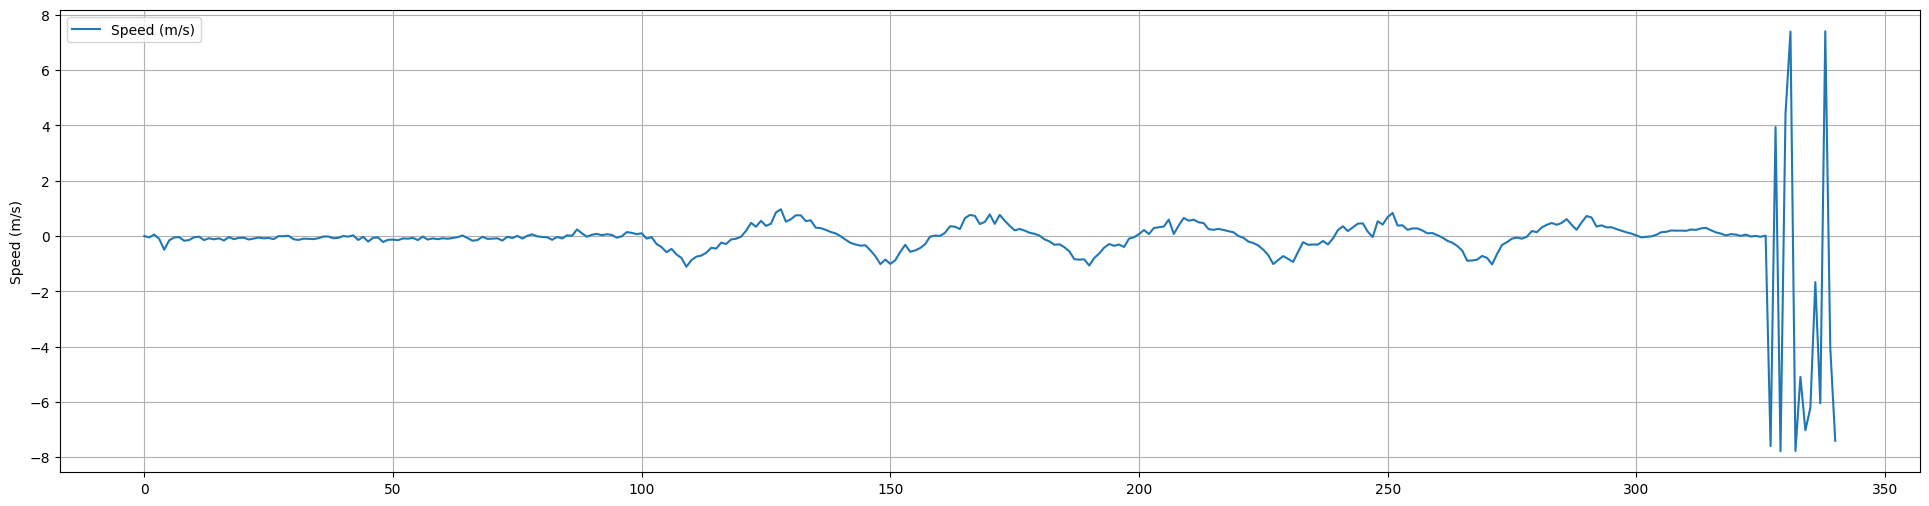

In [12]:
plot_trial_dataframe(FIFTEEN_DEG_SAMPLES['15-t10'])

In [13]:
WFS_FIFTEEN_DEG = {
    '15-t1': WaveFilter(x_min=5, x_max=15),
    '15-t2': WaveFilter(x_min=7.5, x_max=17.5),
    '15-t3': WaveFilter(x_min=6.5, x_max=17.5),
    '15-t4': WaveFilter(x_min=7.5, x_max=17.5),
    '15-t5': WaveFilter(x_min=7.5, x_max=17.5),
    '15-t6': WaveFilter(x_min=5, x_max=20),
    '15-t7': WaveFilter(x_min=6, x_max=16.5),
    '15-t8': WaveFilter(x_min=4, x_max=15),
    '15-t9': WaveFilter(x_min=5, x_max=15),
    '15-t10': WaveFilter(x_min=6, x_max=15.5),
}

15-t1
[0.164009822001236, 0.718002866257204, 0.926325329548769, 0.876216068295002, 1.02243926429304, 0.919278204133096]
[0.0037595367041953, -0.894684787174822, -1.23924914221233, -1.13893138900655, -0.963448216582932, -0.806701173155138]
trial avg v: 0.9505276440658884
~~~~~~
15-t2
[-0.12769134687741, 1.28103711241787, 0.927680646858786, 0.93359107784746, 0.902420878726153, 0.809774130044592]
[-0.959862384437034, -0.0303728200978126, -0.668886988630257, -0.8504112558757, -0.921390685947077, -0.816178756588473]
trial avg v: 0.9071233917373401
~~~~~~
15-t3
[0.913475003456505, 0.846979384301201, 0.931422151468675, 0.890663336414084, 0.928339003437357]
[-1.20132568682913, -1.04325974796349, -0.989472198292307, -1.18484987685475, -1.08009051811442]
trial avg v: 1.0009876907131918
~~~~~~
15-t4
[-0.0855510501429668, 1.05519131748027, 1.18381613933723, 1.15530241853596, 0.905229520287991, 0.114041287348126, 0.855705265724429]
[-0.593071281553432, -0.0370667328535479, -0.687792047231035, -0.75

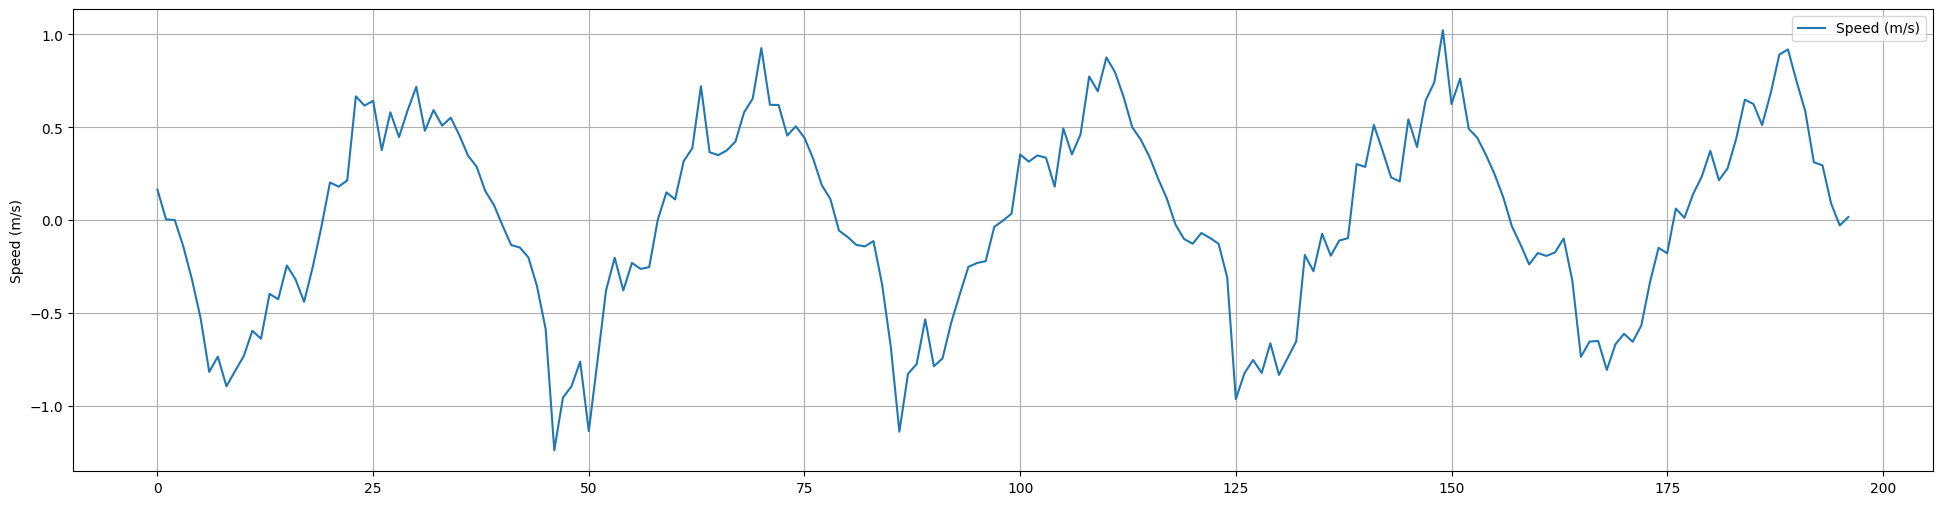

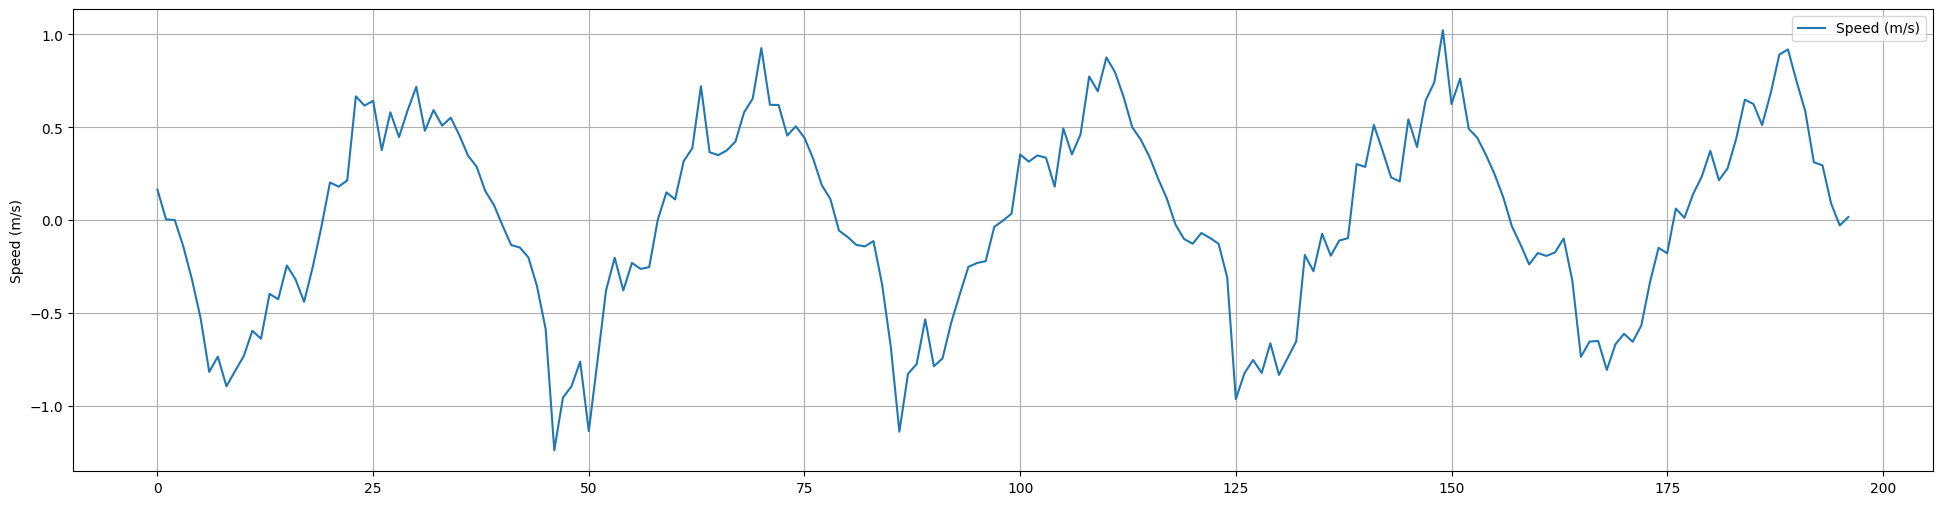

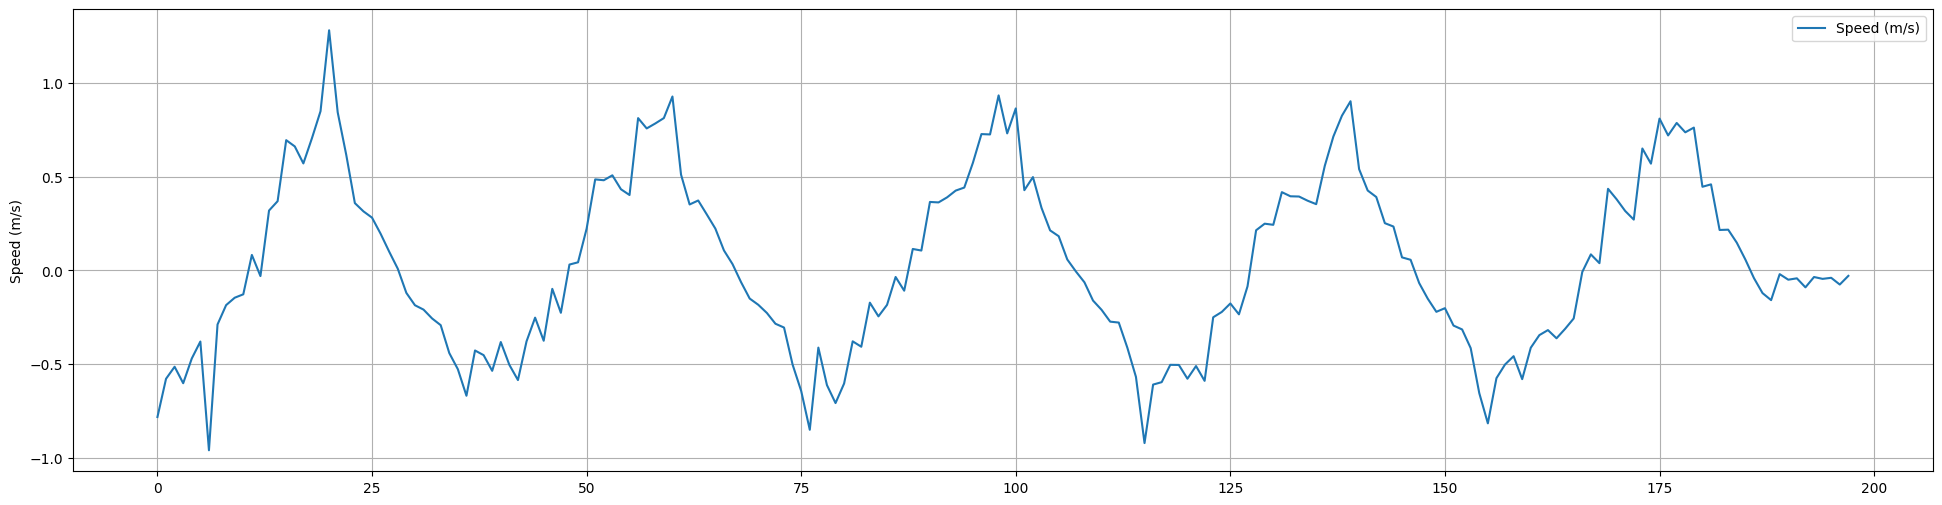

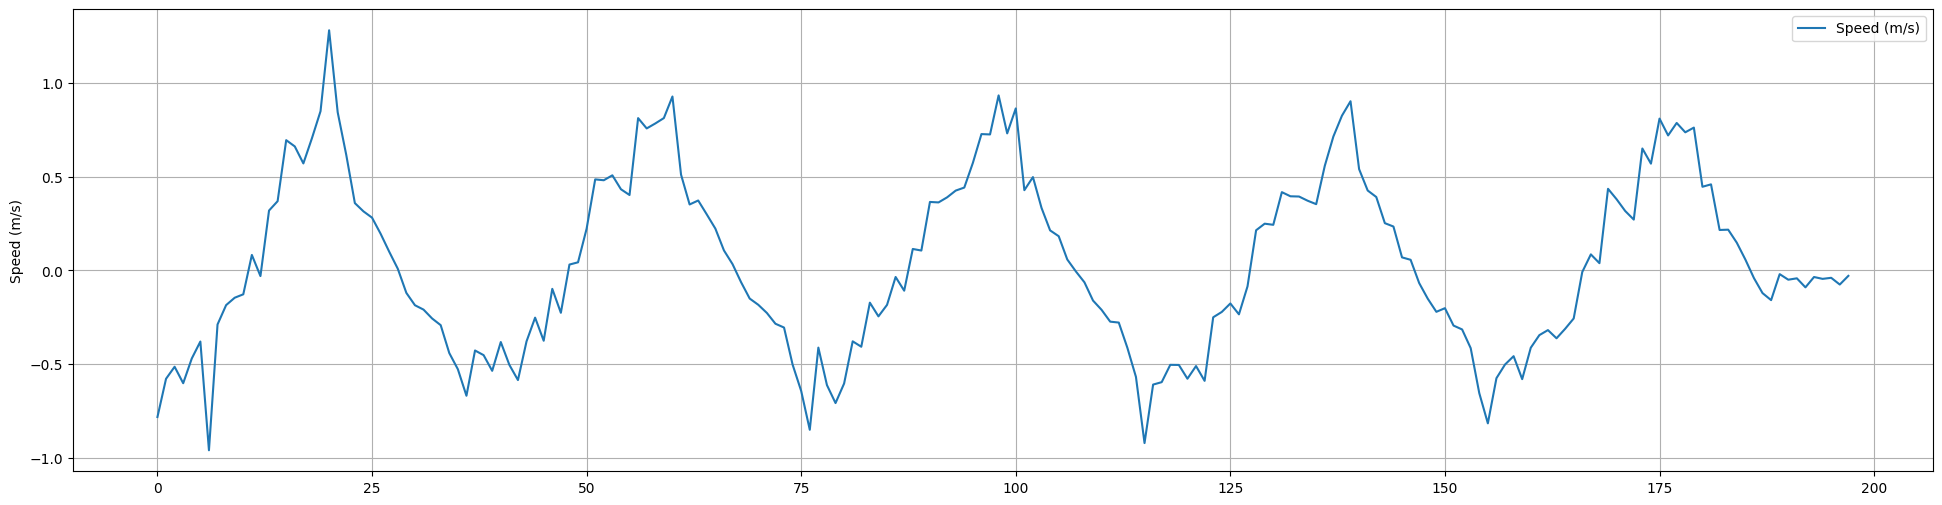

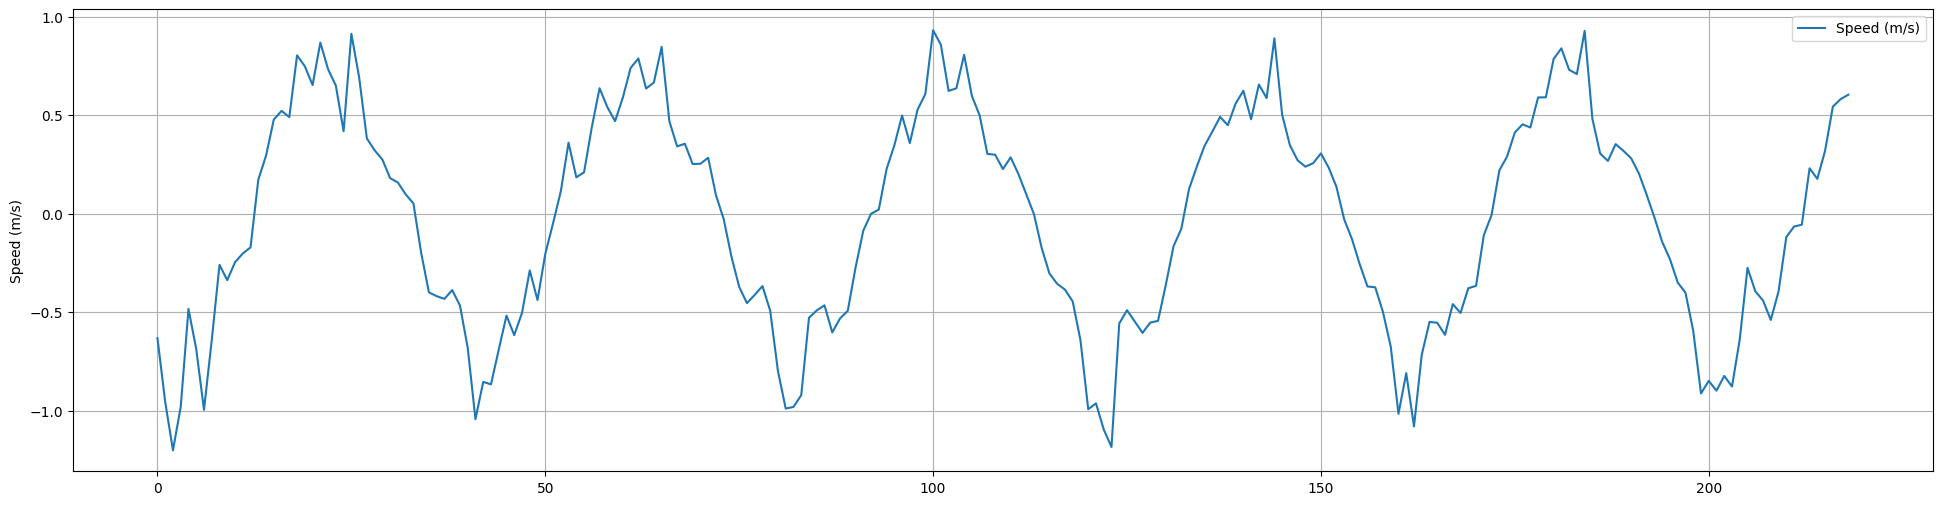

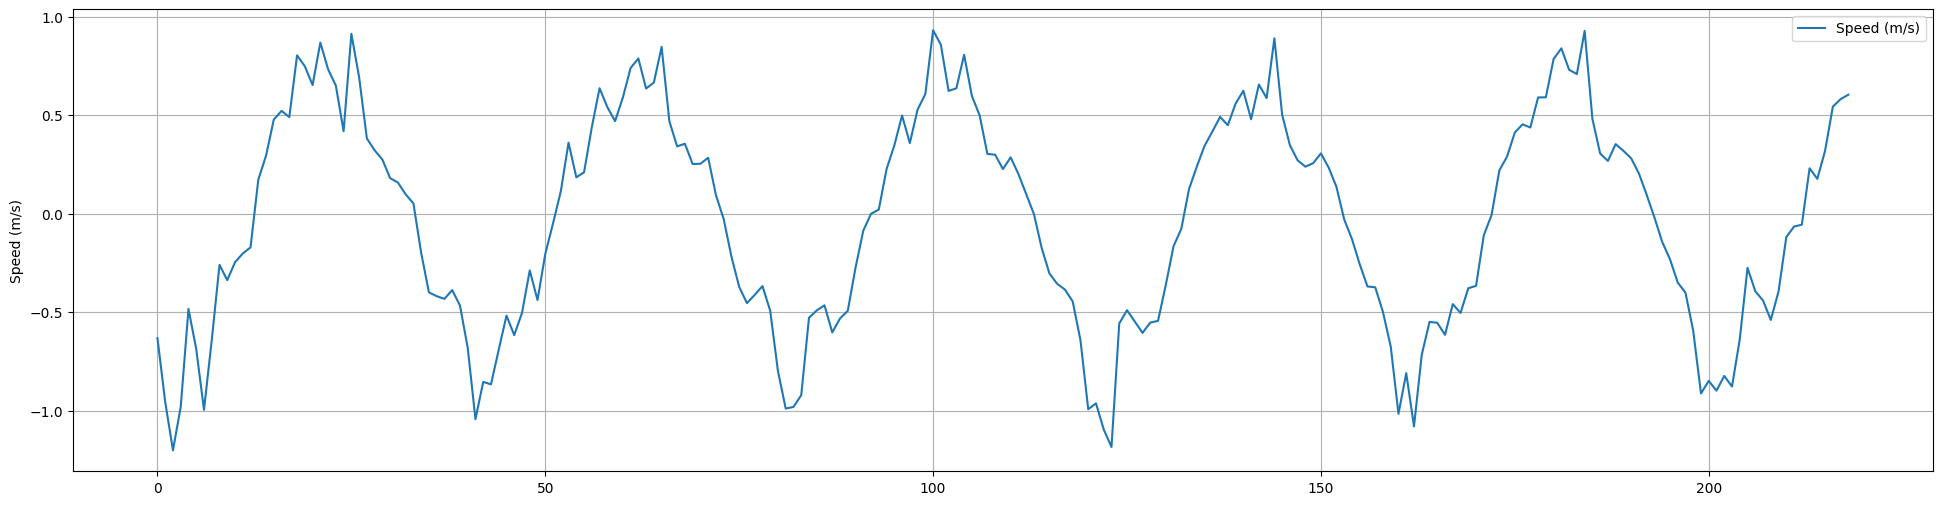

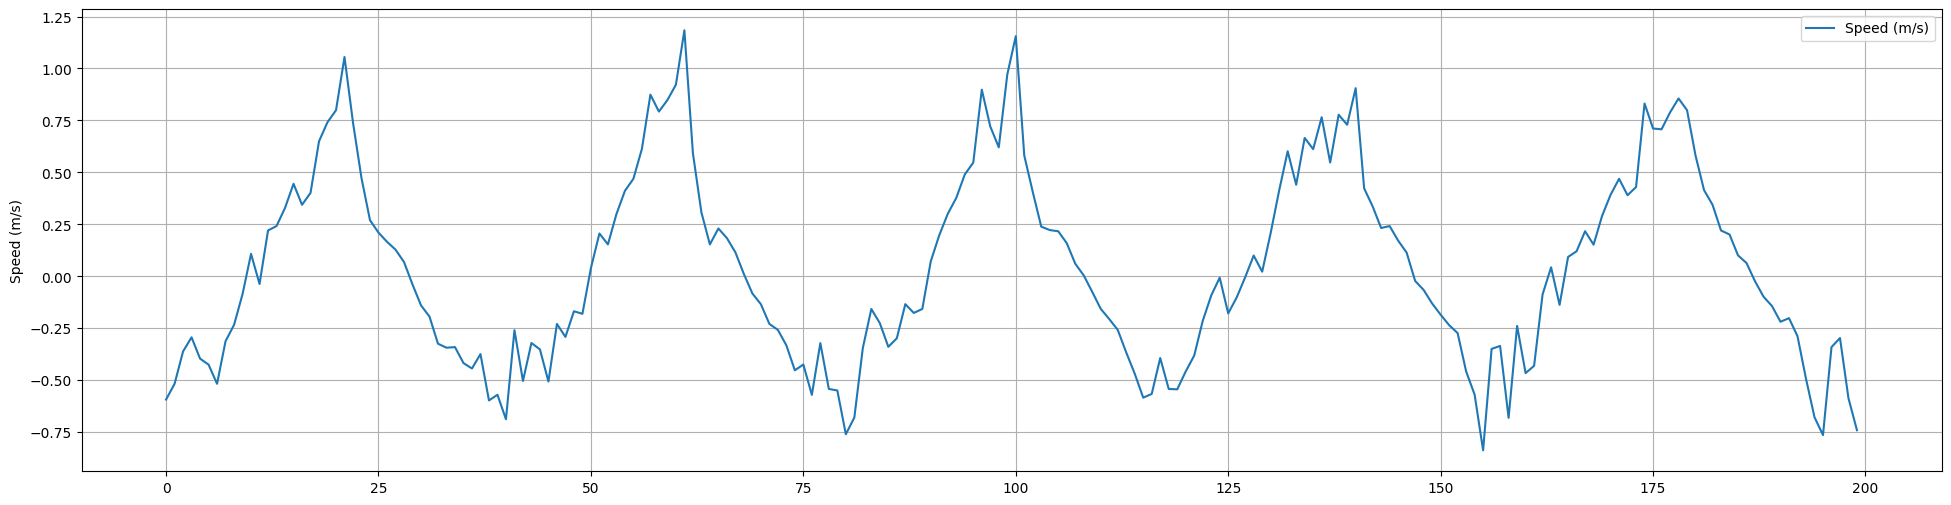

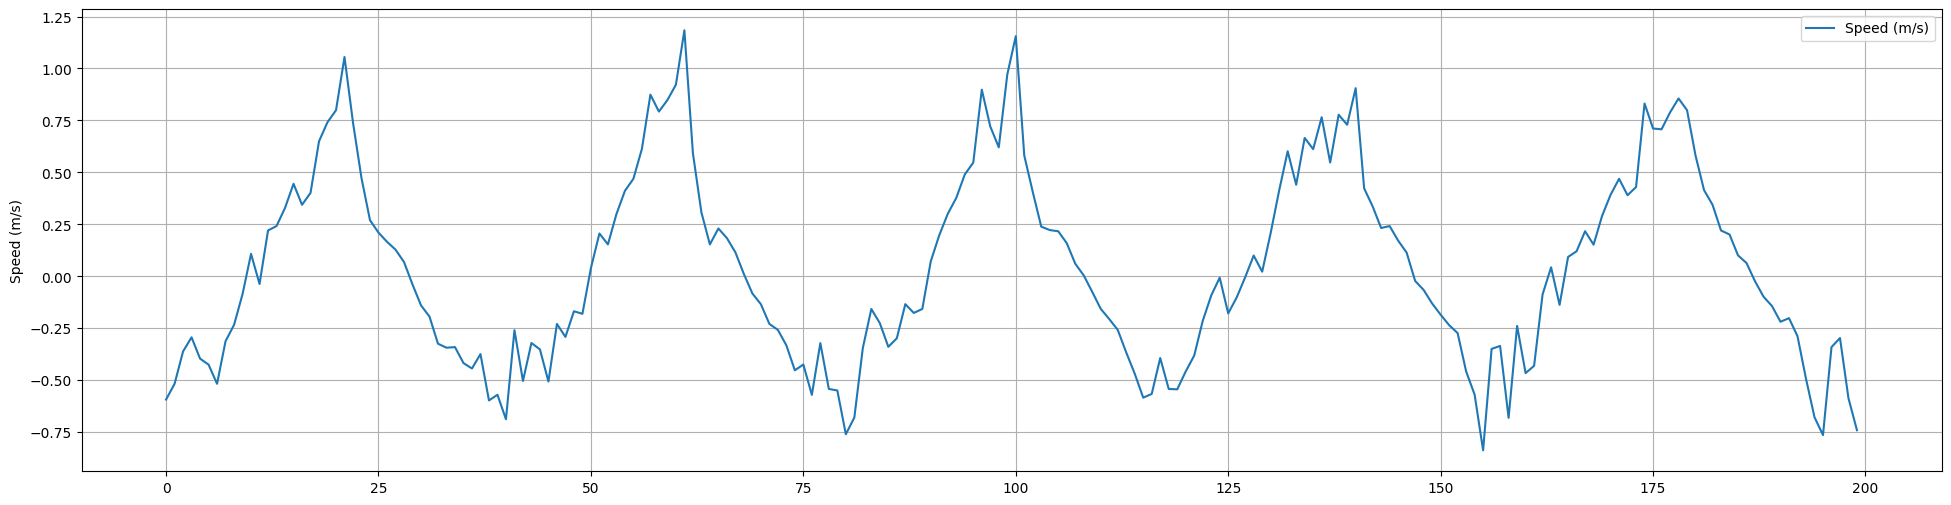

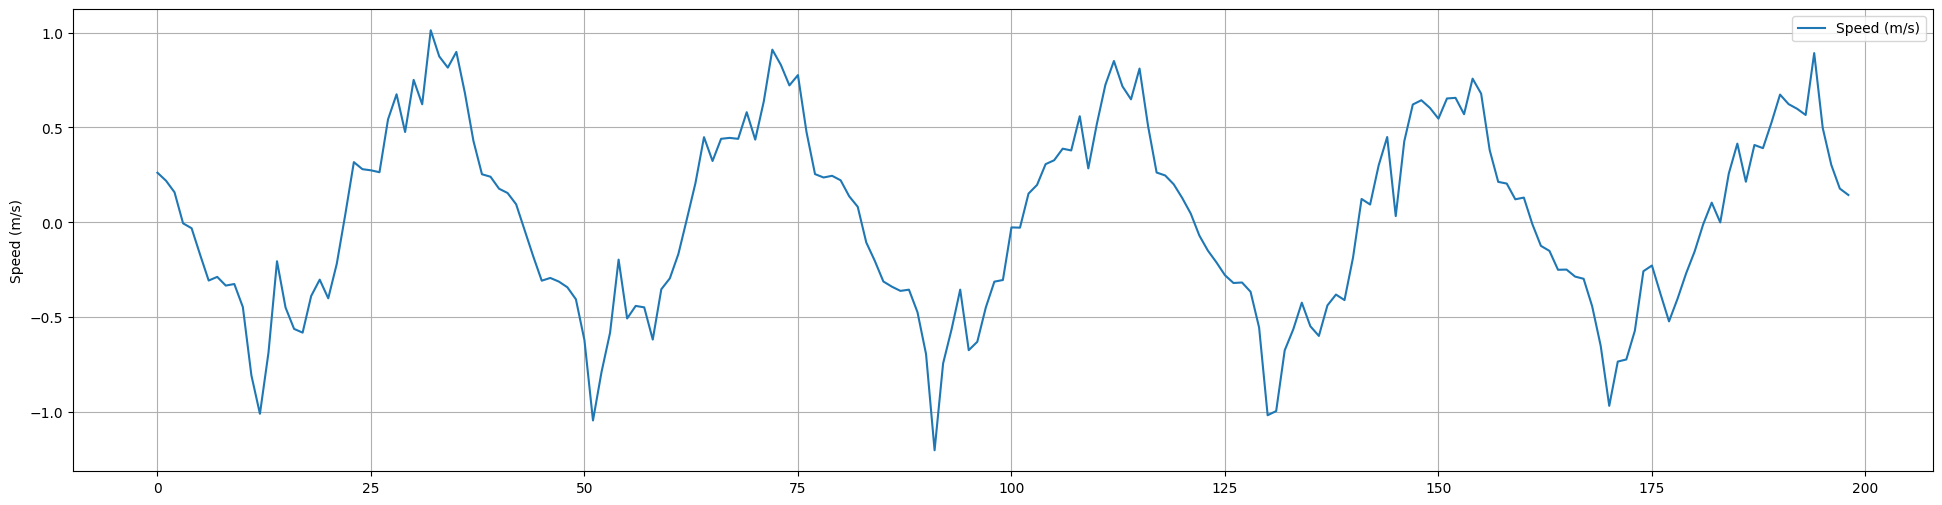

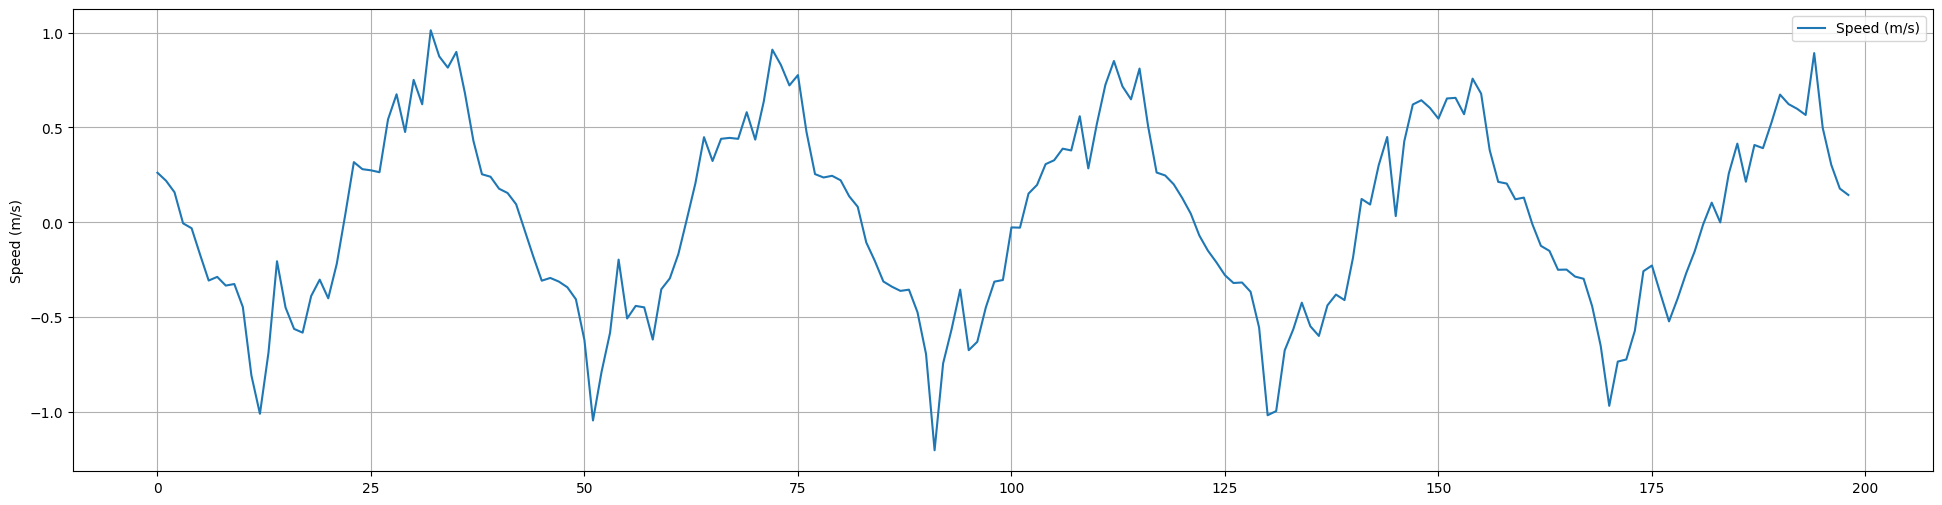

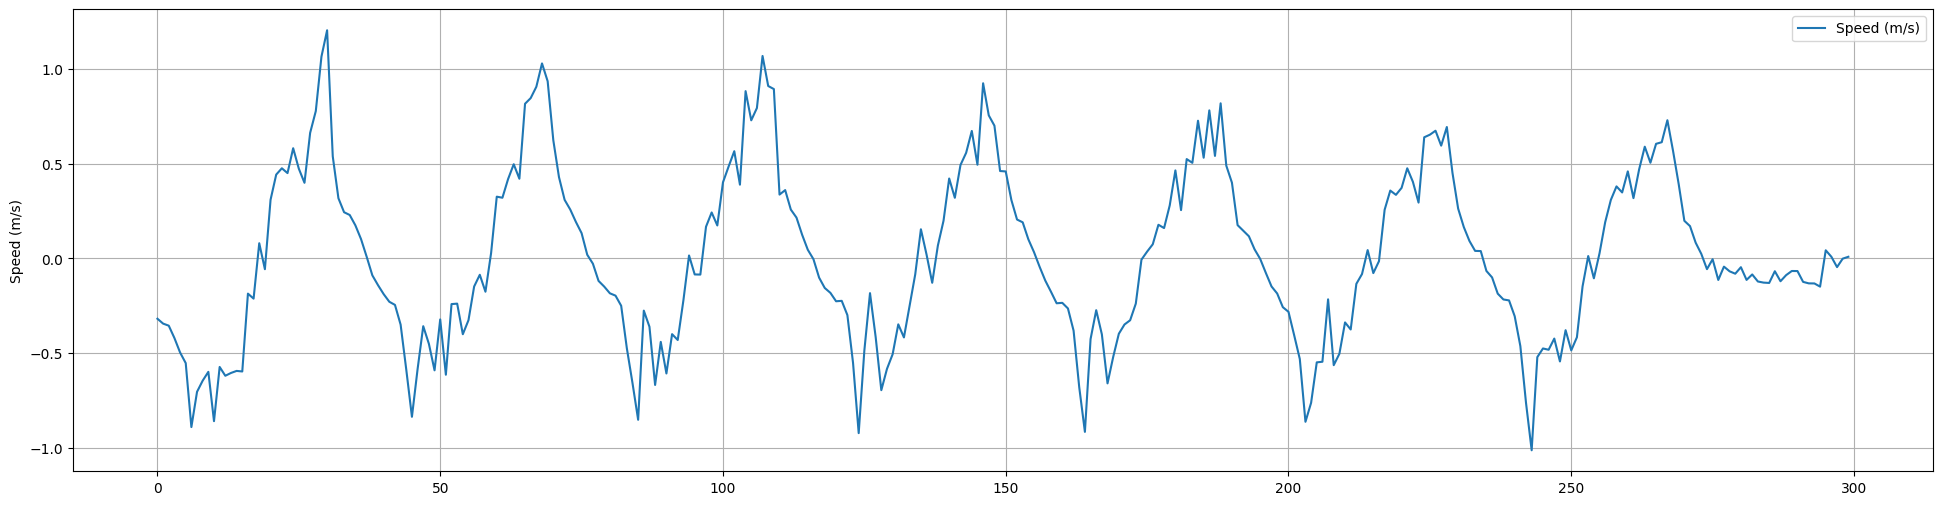

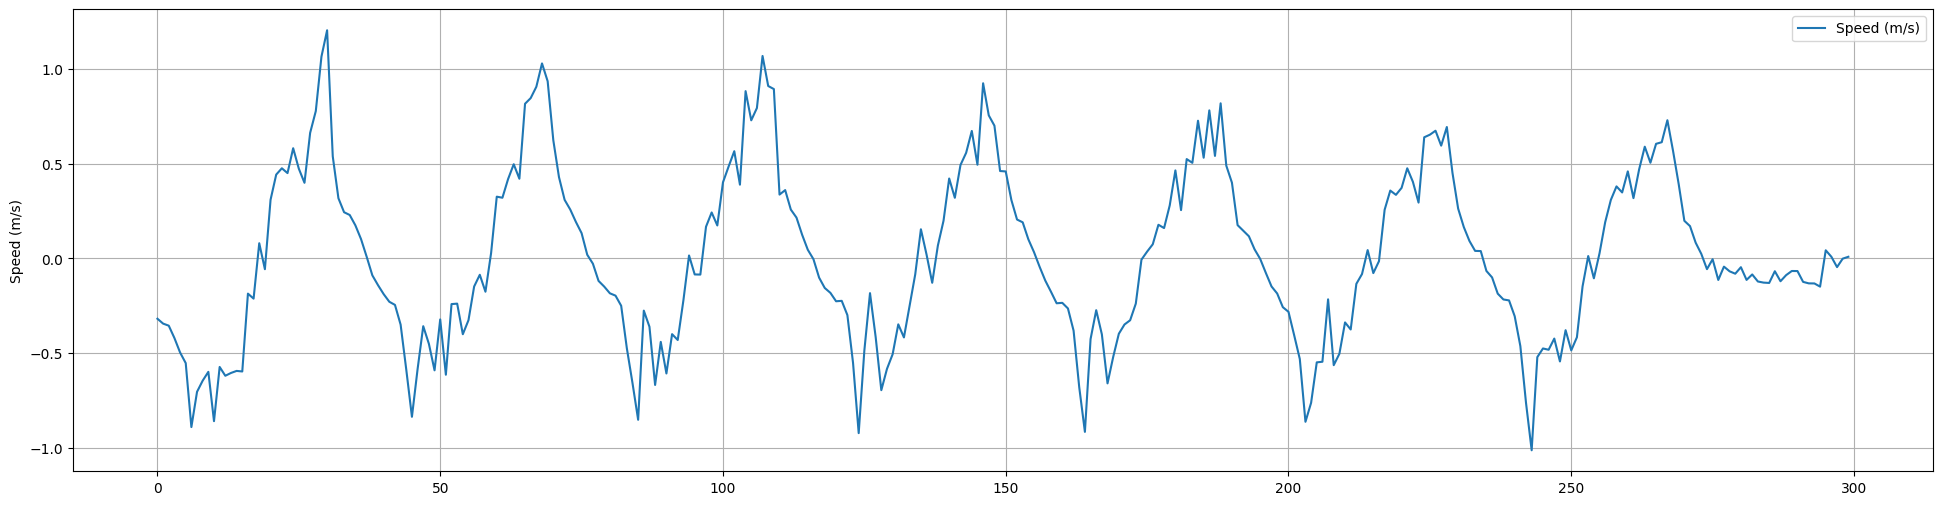

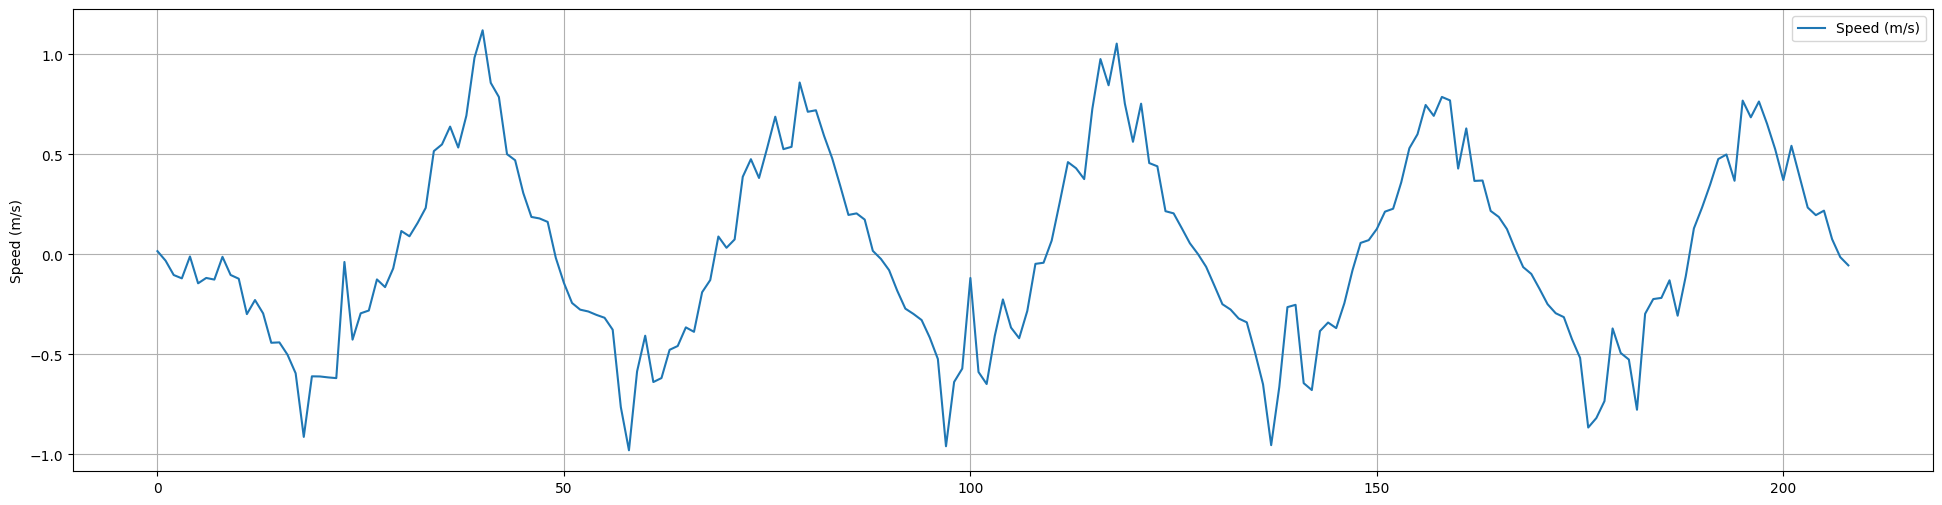

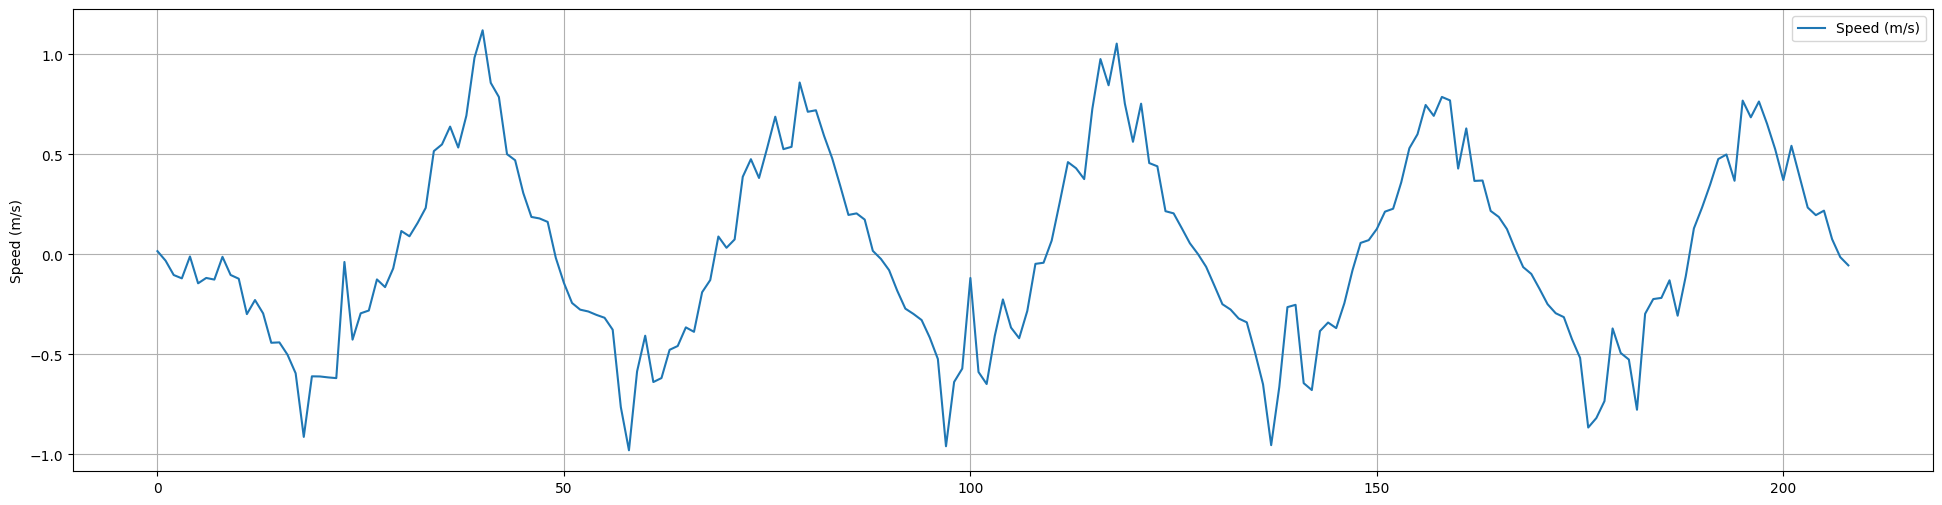

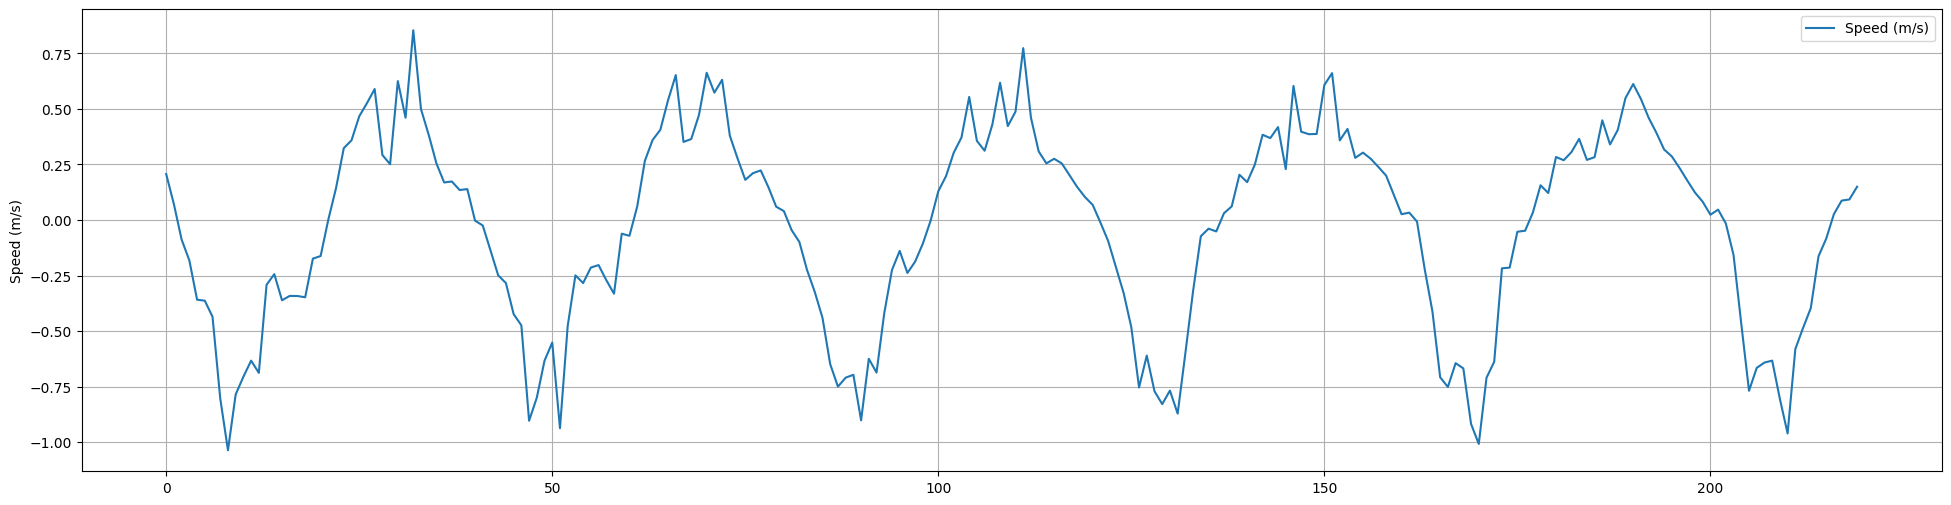

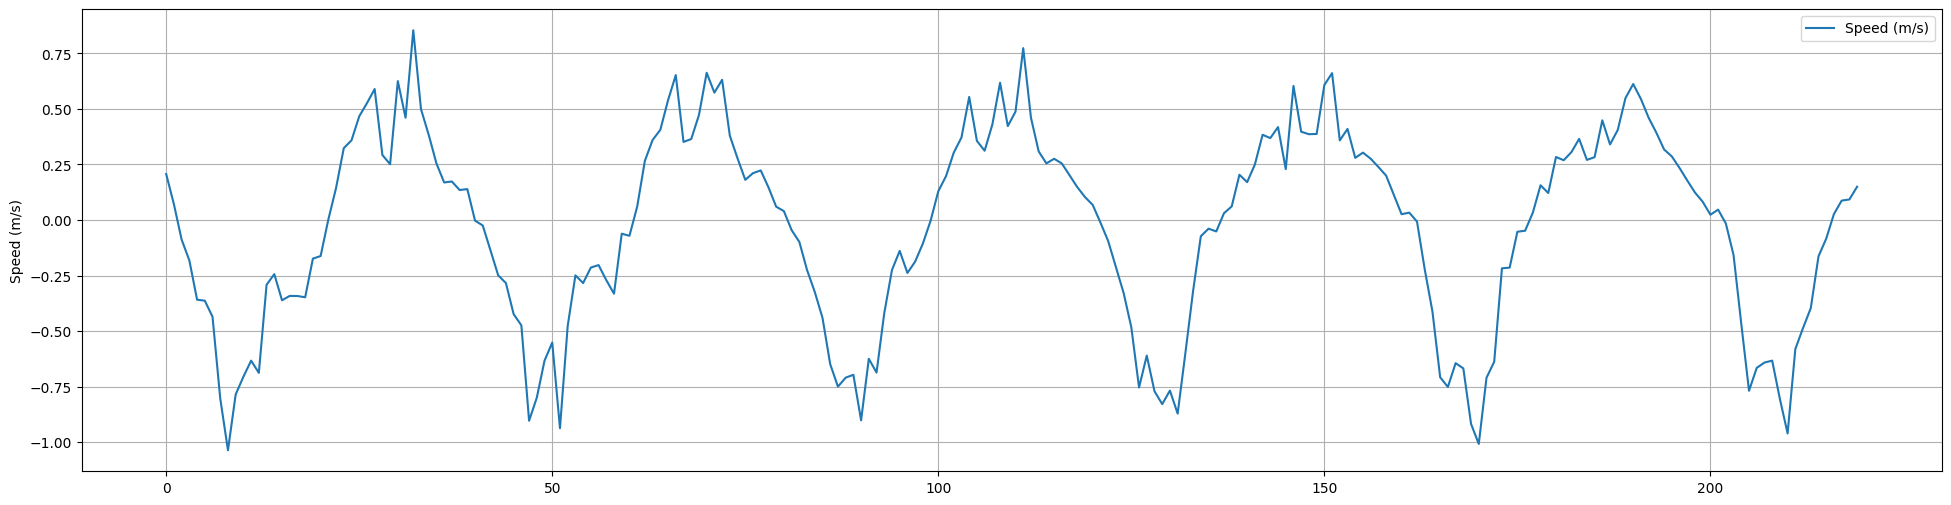

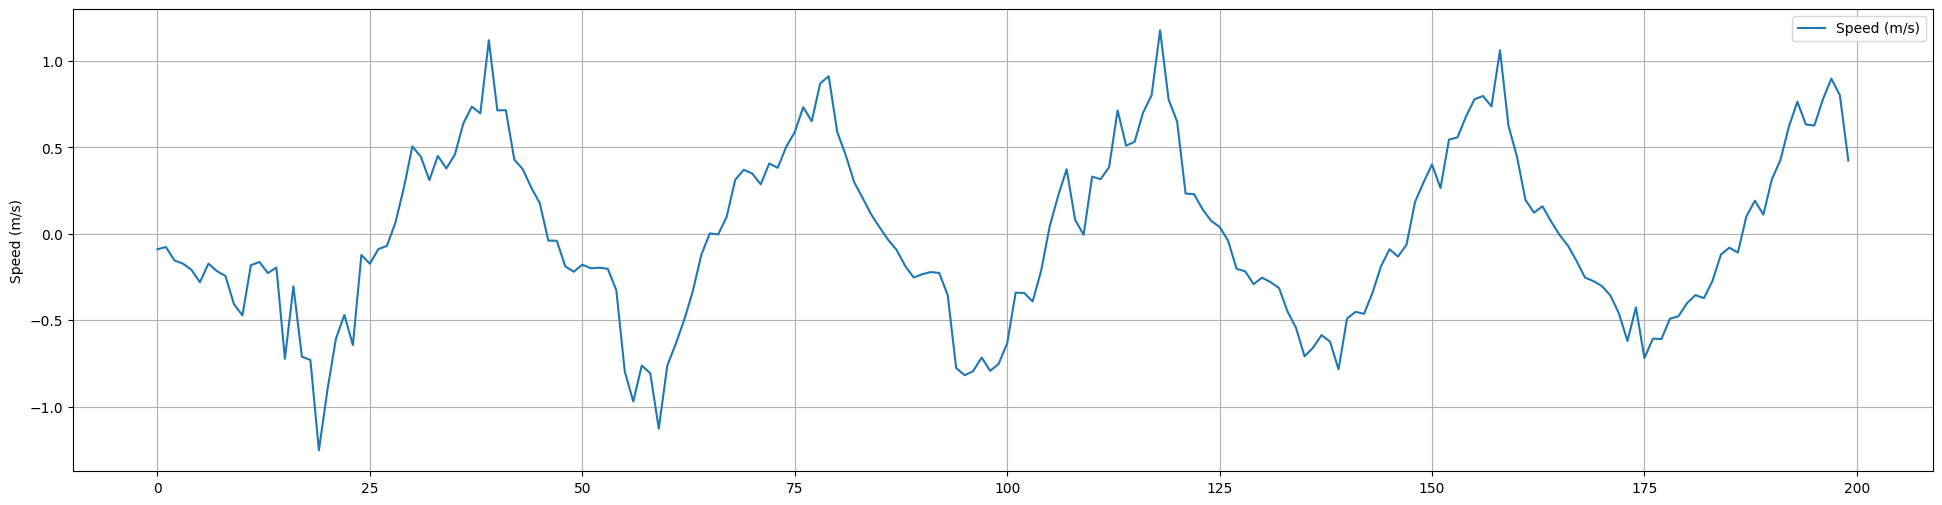

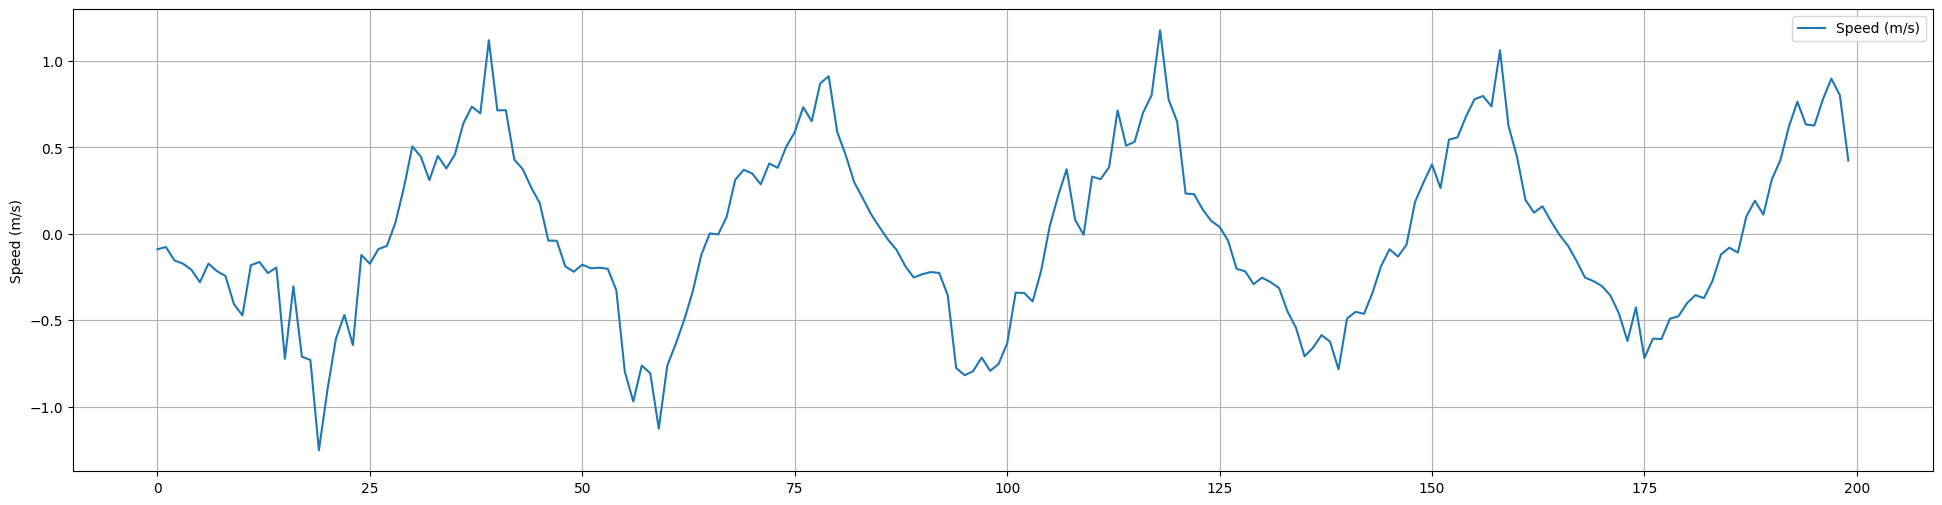

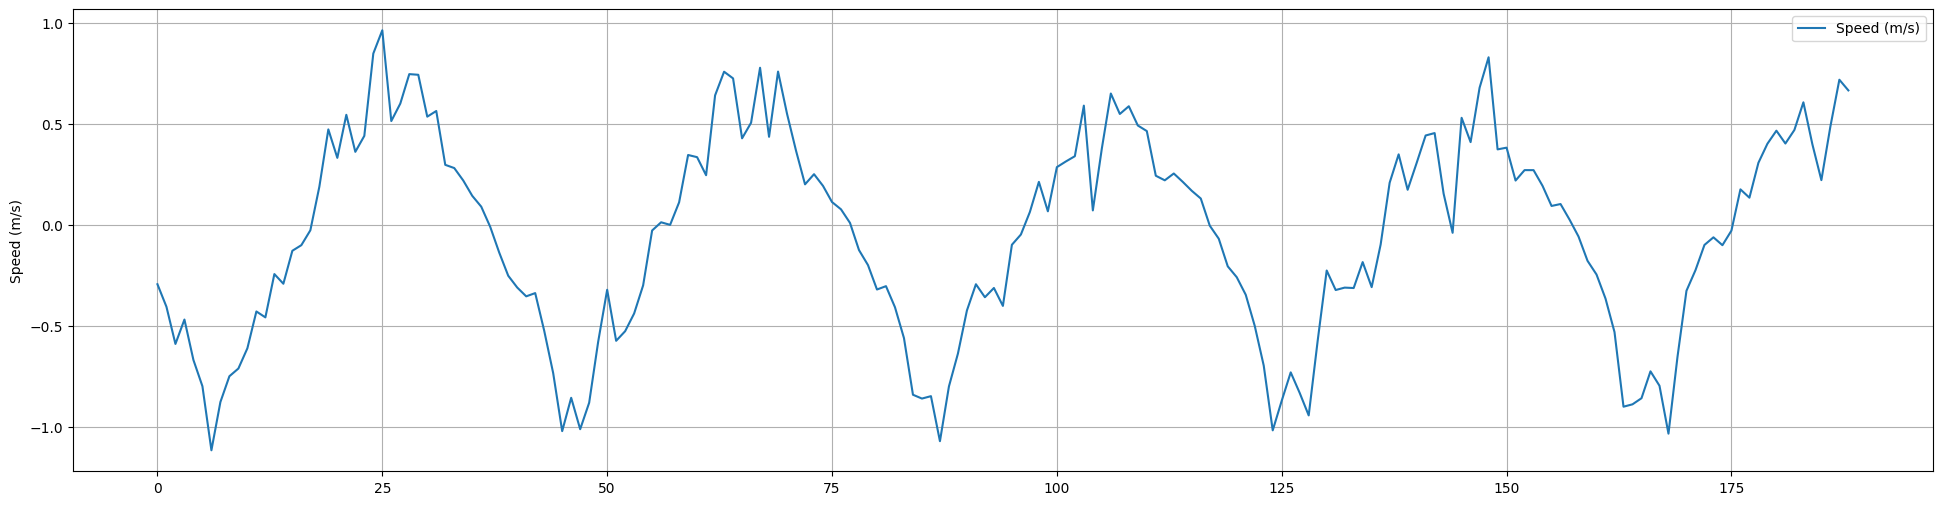

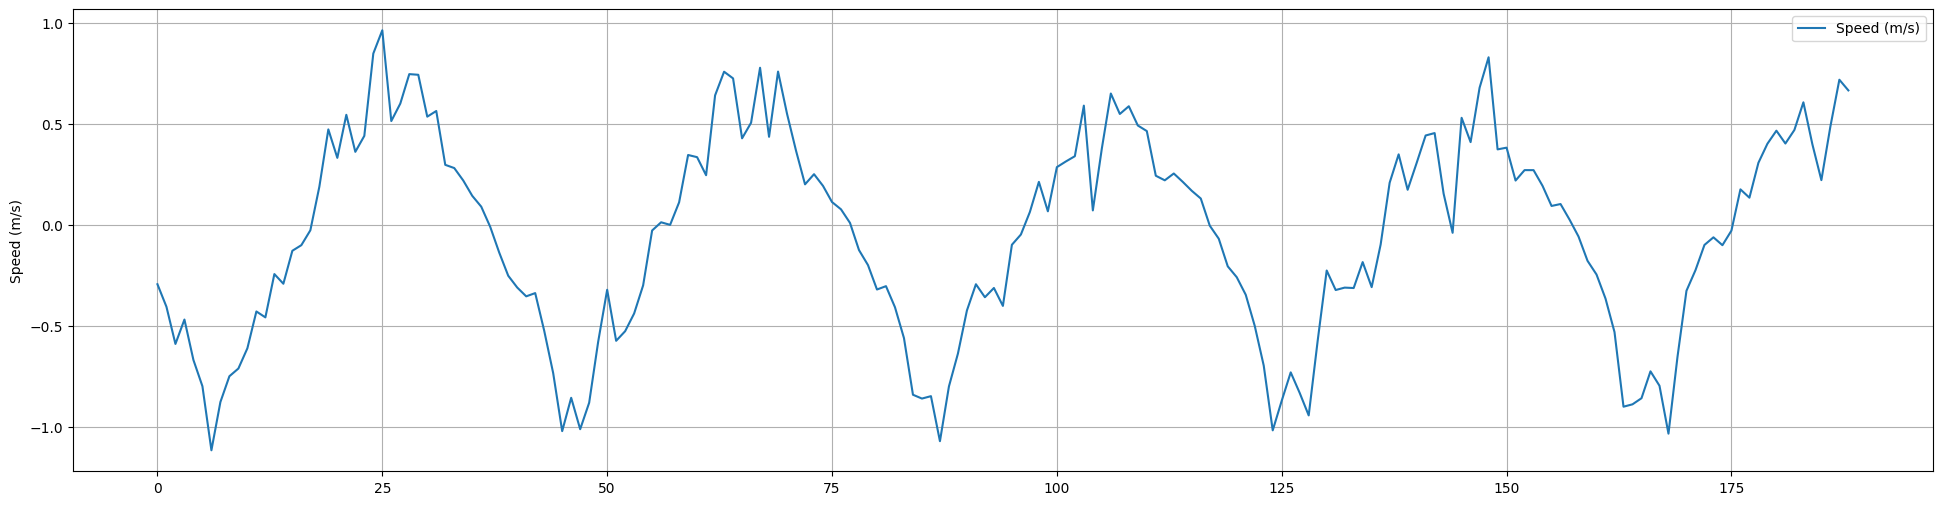

In [14]:
fifteen_avglist, fifteen_stdev = run_experimental_computation(FIFTEEN_DEG_SAMPLES, WFS_FIFTEEN_DEG, '15deg')

In [15]:
def generate_trial_graph(results):
    trial_df_data = {
        'Trial': range(1, 11),
        'Velocity': results
    }
    trial_df = pd.DataFrame(data=trial_df_data)
    plot_trial_dataframe(trial_df, graph_type='scatter', xlabel='Trial', ylabel='Velocity', yerr=fifteen_stdev)

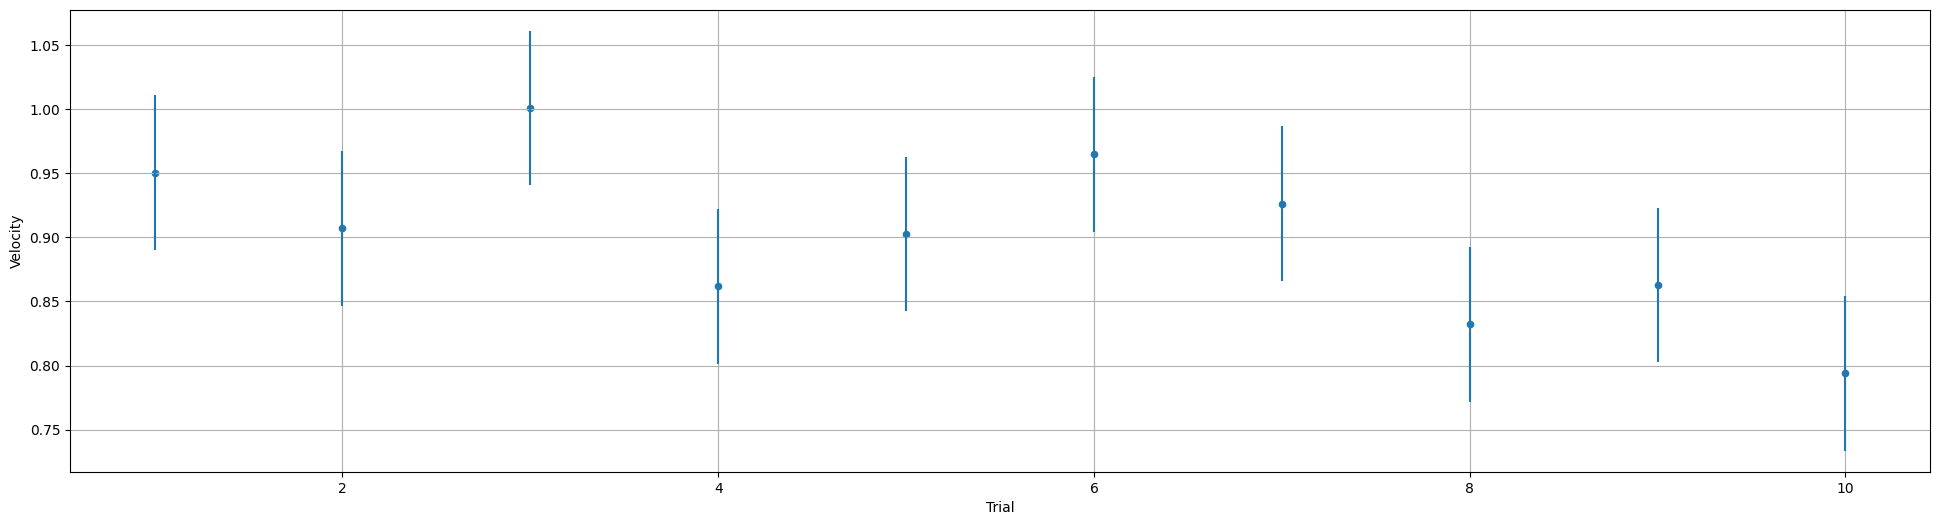

In [16]:
generate_trial_graph(fifteen_avglist)

## 20

## 25

## 30

In [17]:
THIRTY_DEG_SAMPLES = read_in_trials(30)

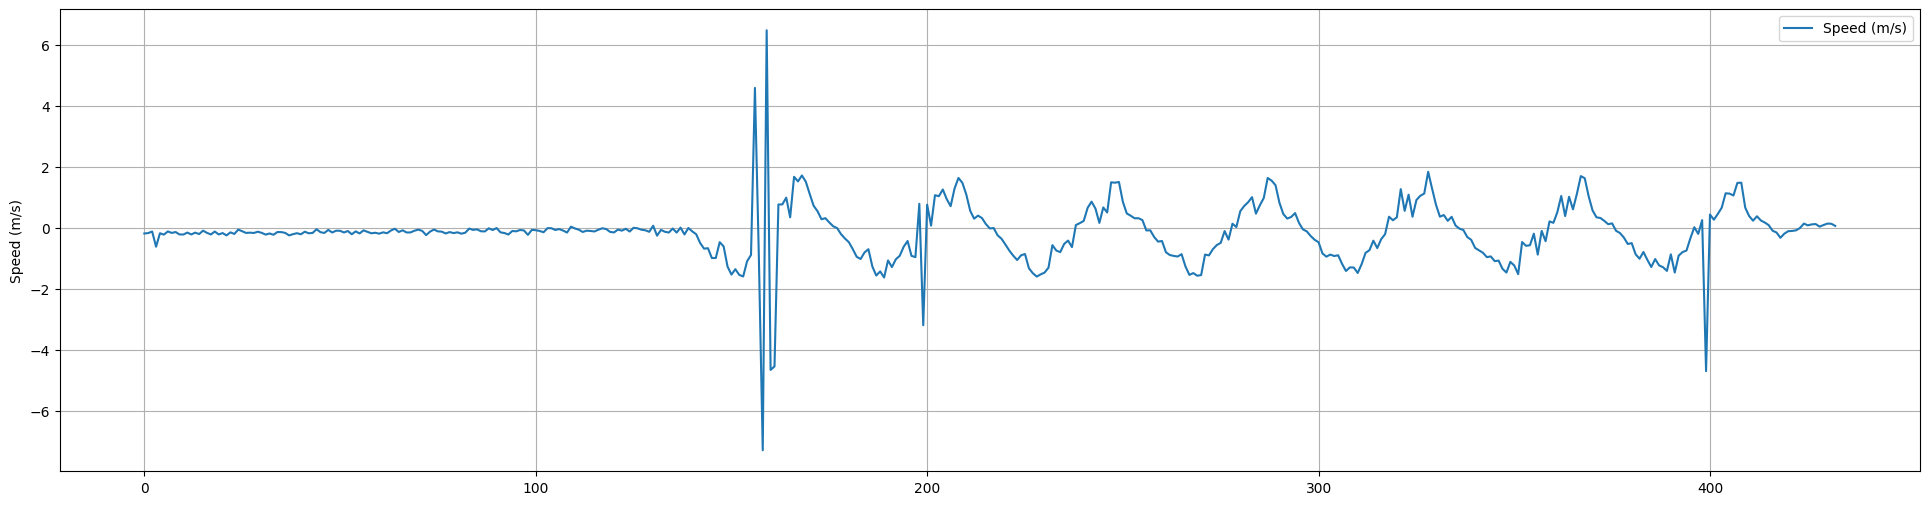

In [18]:
plot_trial_dataframe(THIRTY_DEG_SAMPLES['30-t10'])

In [19]:
WFS_THIRTY_DEG = {
    '30-t1': WaveFilter(x_min=8, x_max=19),
    '30-t2': WaveFilter(x_min=8, x_max=18),
    '30-t4': WaveFilter(x_min=10, x_max=20),
    '30-t5': WaveFilter(x_min=13, x_max=23),
    '30-t6': WaveFilter(x_min=8, x_max=21),
    '30-t7': WaveFilter(x_min=7, x_max=20, y_min=-2),
    '30-t8': WaveFilter(x_min=13, x_max=25),
    '30-t9': WaveFilter(x_min=13, x_max=25, y_min=-2),
    '30-t10': WaveFilter(x_min=10, y_min=-2),
}

30-t1
[-0.0175078684134311, 0.0702845314980438, 0.0419826440025117, 0.0256300155932476, 1.84909024835283, 1.80396363142261, 1.59523501117145, 1.48852709317837, 1.47099470758815, 0.149343926683418]
[-0.0315836683645188, -0.0343016720016154, -0.15131592884694, -1.97357740624454, -0.56308888862084, -1.6984918565576, -1.79291037601086, -1.72148843392784, -1.58713914321408, -0.524060683712624]
trial avg v: 1.698141790766833
~~~~~~
30-t2
[1.61821534357903, 1.69366244087676, 0.0372612349066404, 1.59459125800289, 0.0807538206080083, 1.54560292007993, 0.120900802230133, 1.51830762332021]
[-1.57717325667387, -1.68696683725082, -1.79878877941381, -0.18189982566247, -1.89782516793553, -0.0093273267779725, -2.02699975345375, -0.153735968266826]
trial avg v: 1.6958133380586602
~~~~~~
30-t3
[-0.0080928676207614, 0.0427836602031451, 0.066319858516557, 0.100592208190615, 0.023920908180437, 0.049906048945596, 0.111679642486366, 0.0016955649009142, 0.0686853865535464, 0.0320948308887514, 1.82267629655609

([1.698141790766833,
  1.6958133380586602,
  1.8493795031094749,
  1.6341366578406398,
  1.4798345056525566,
  1.854811172070645,
  1.626522219993839,
  1.639175322049817,
  1.6284262234266322,
  1.609356078338271],
 0.10651843738257548)

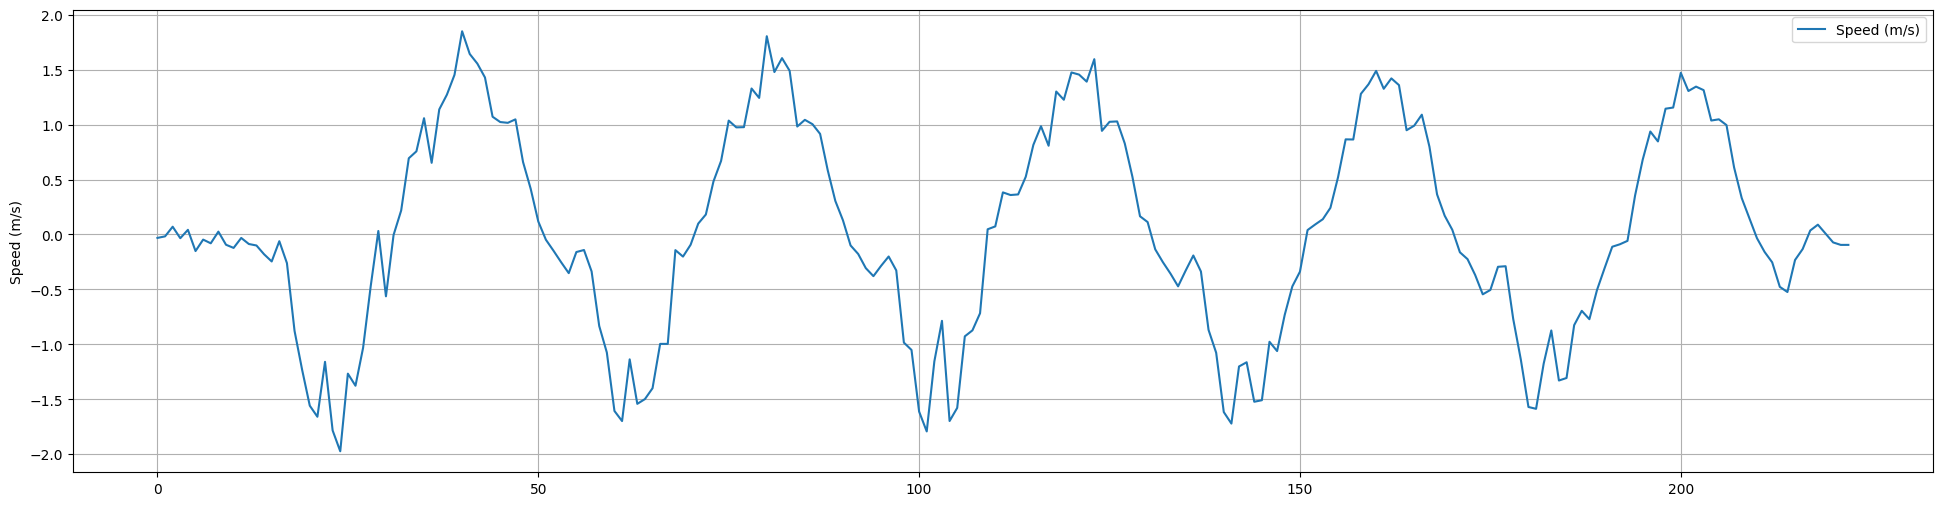

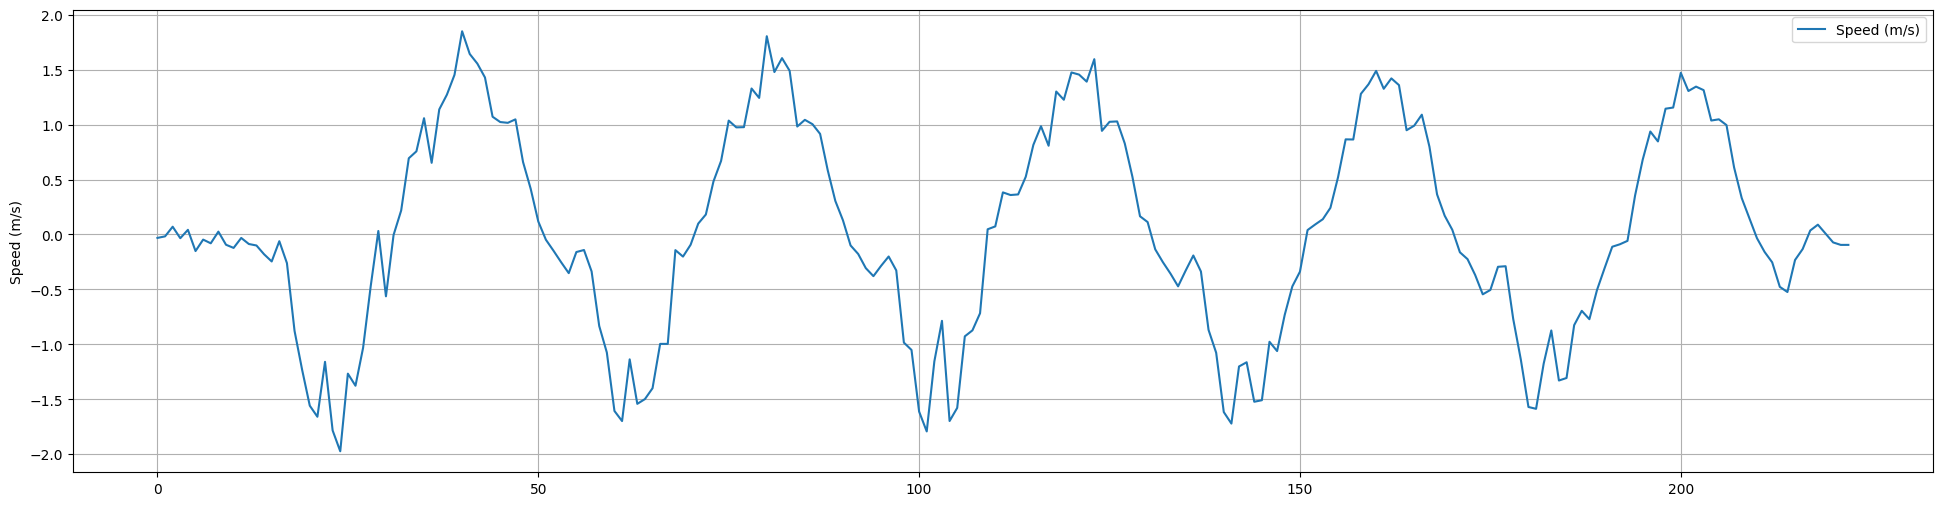

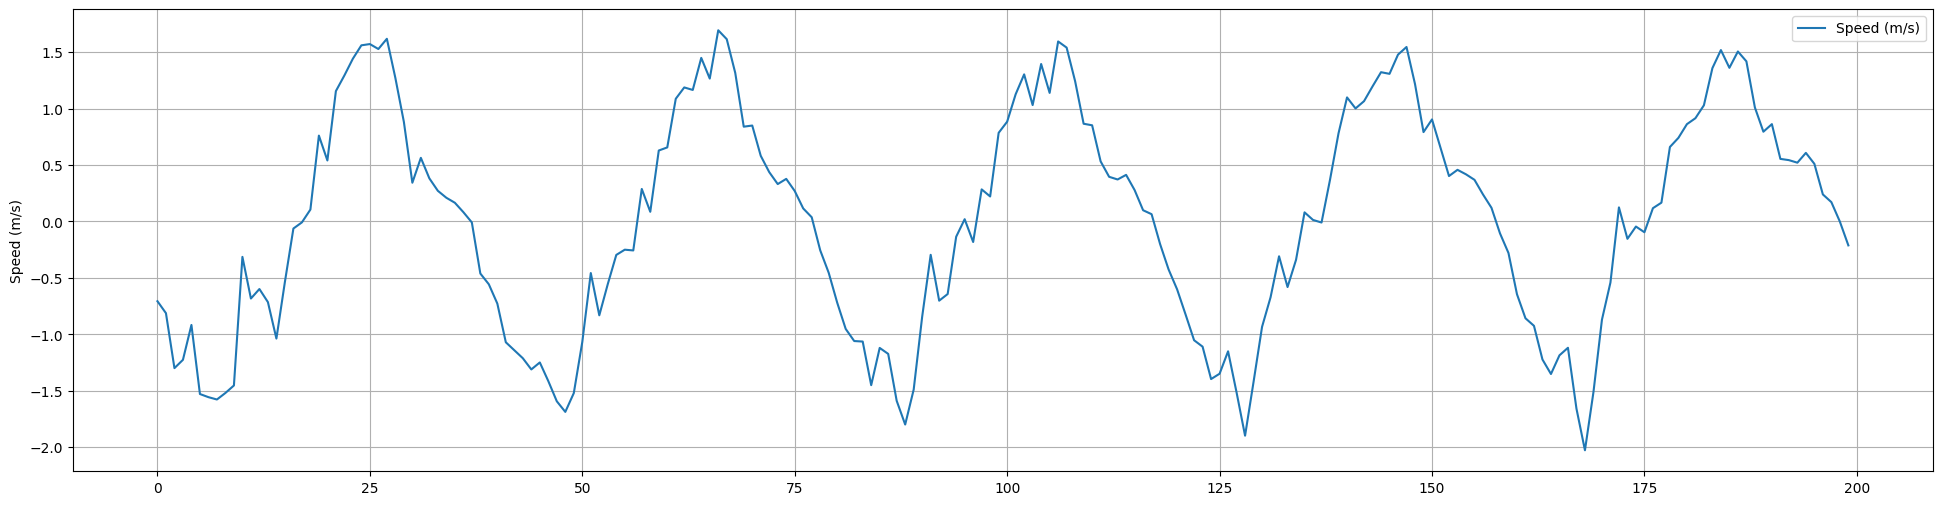

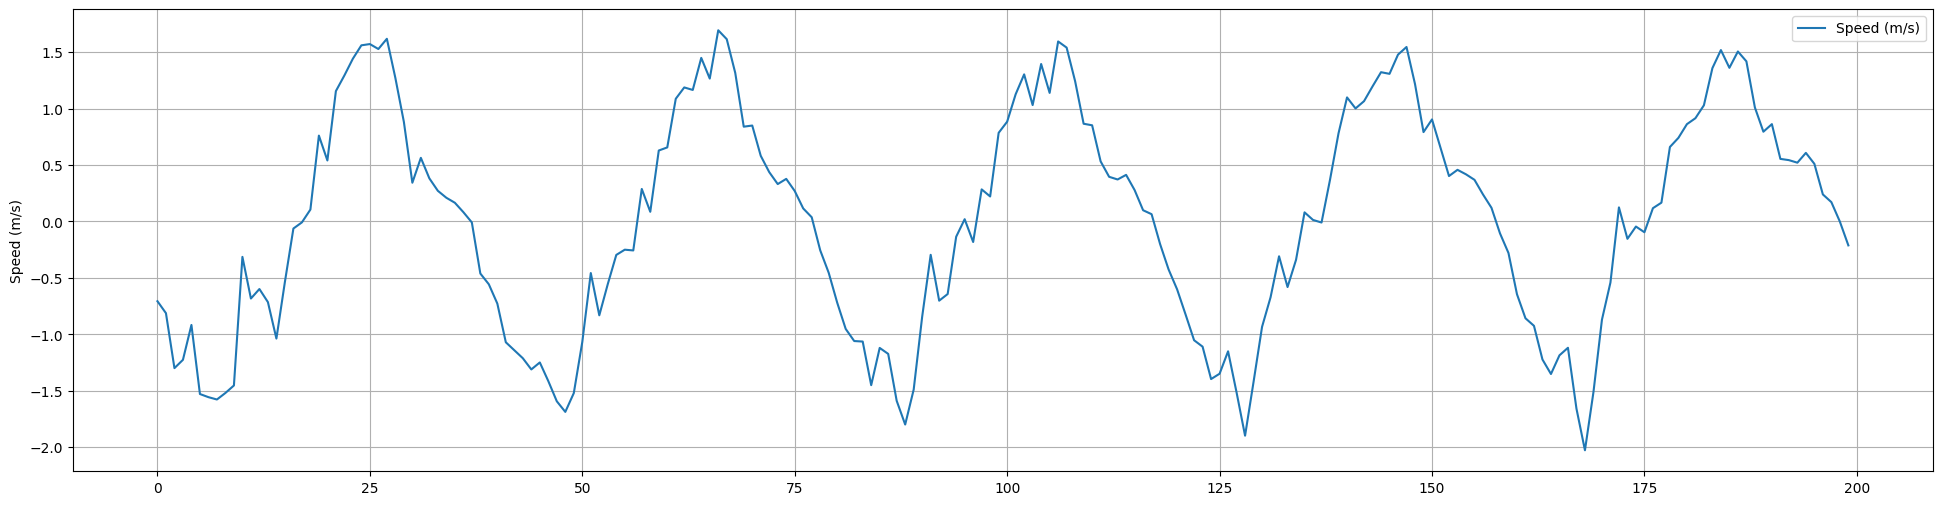

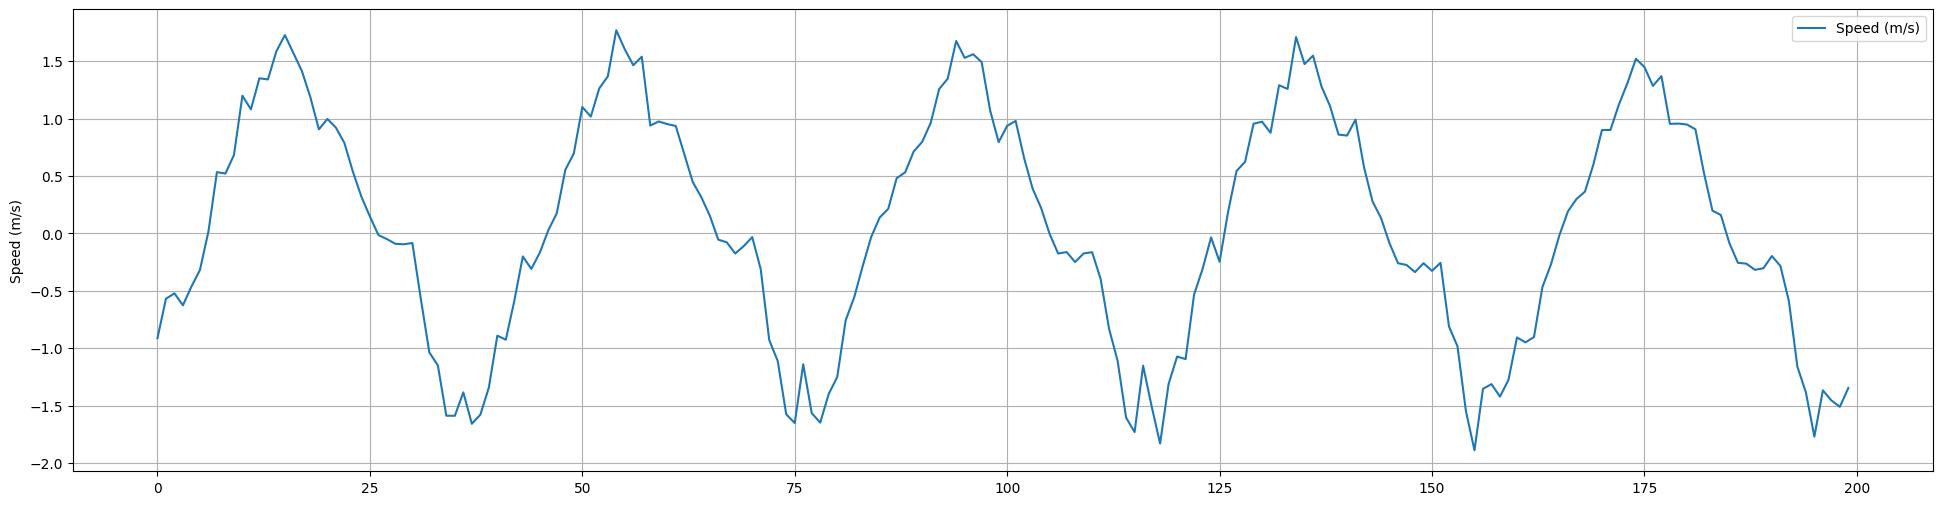

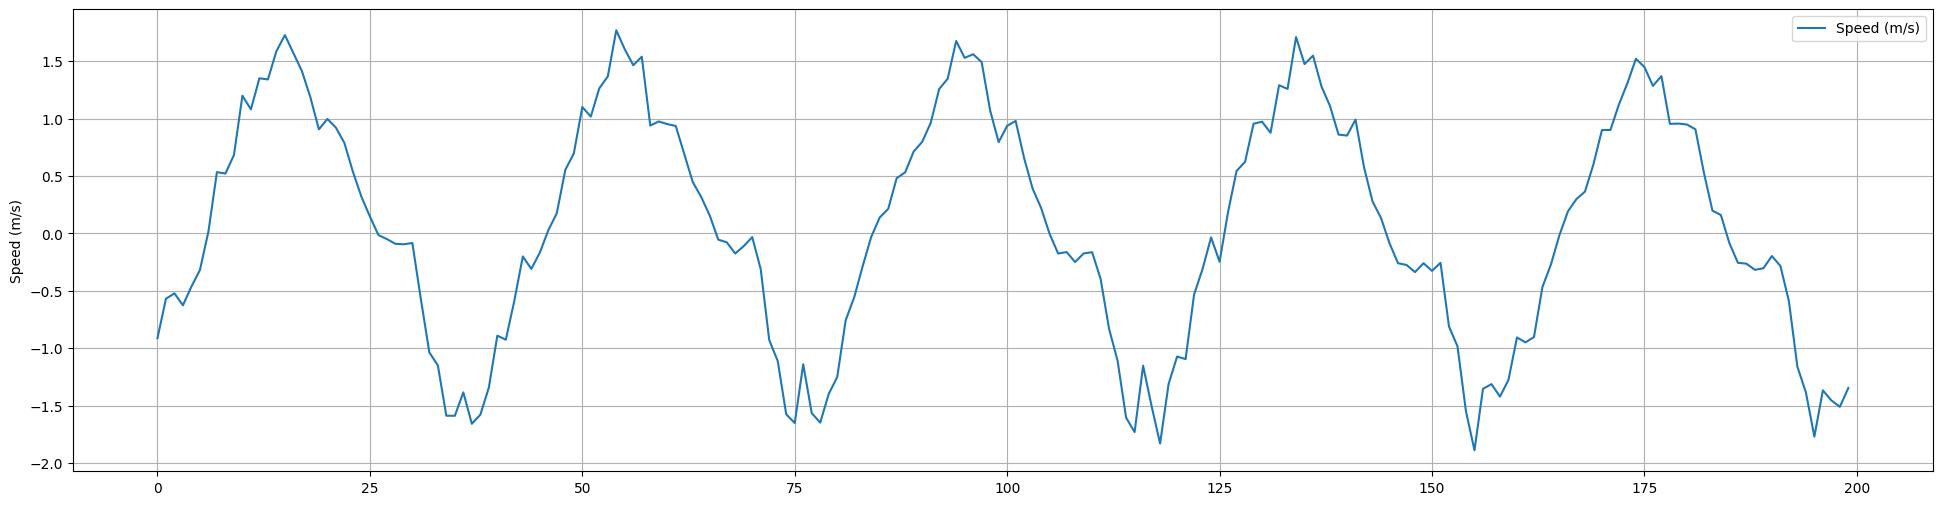

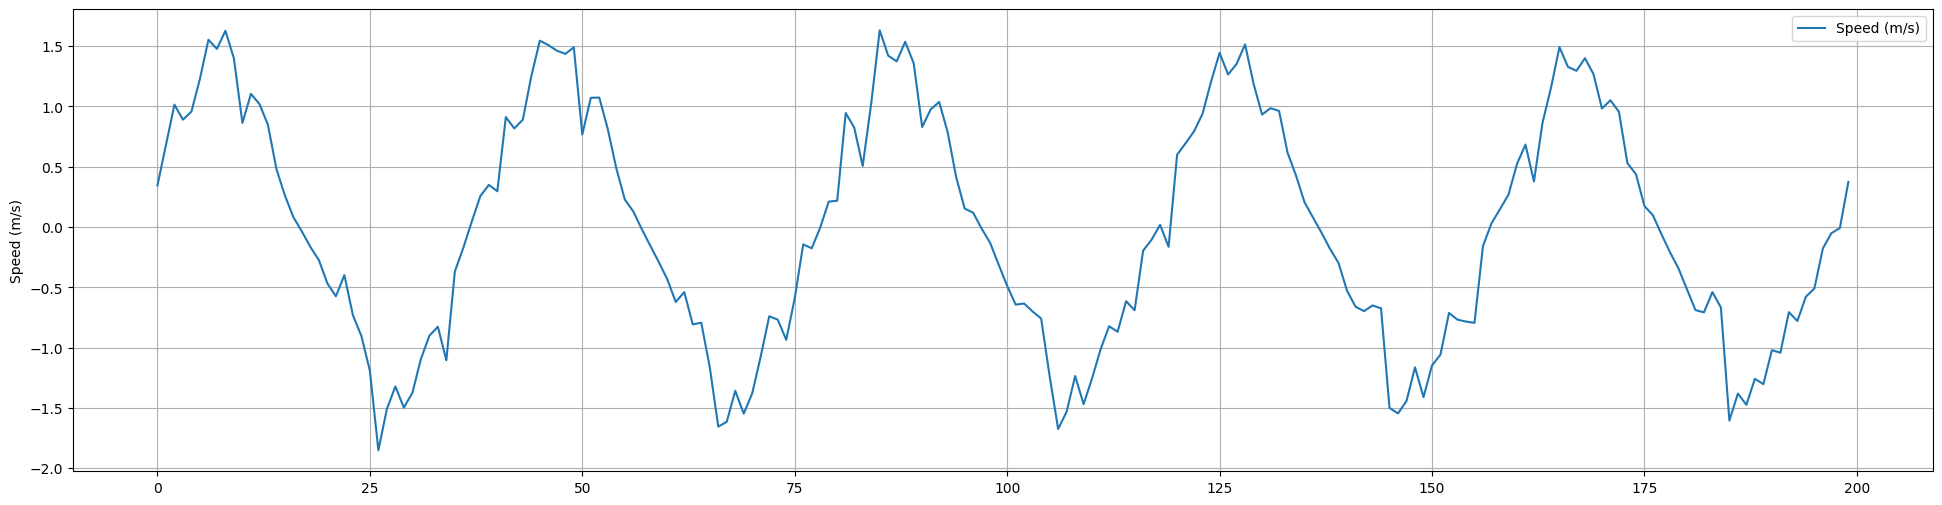

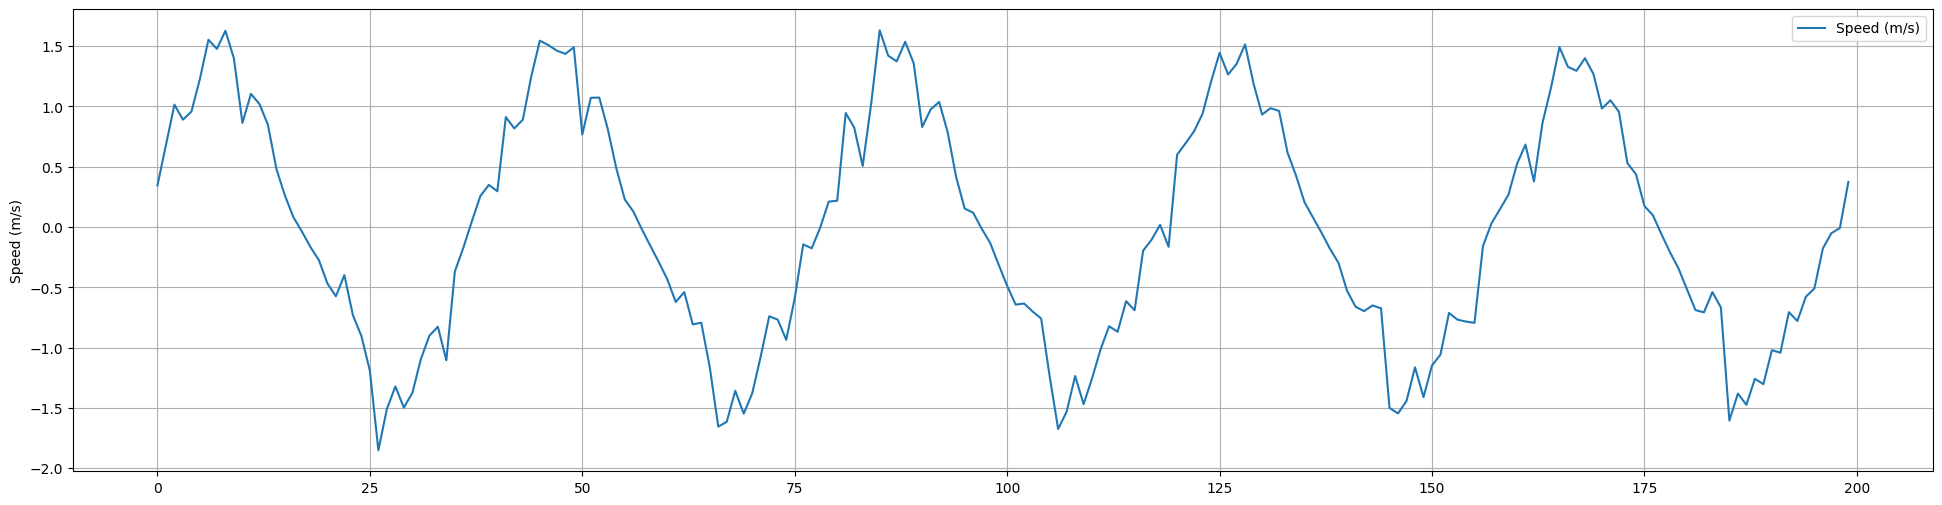

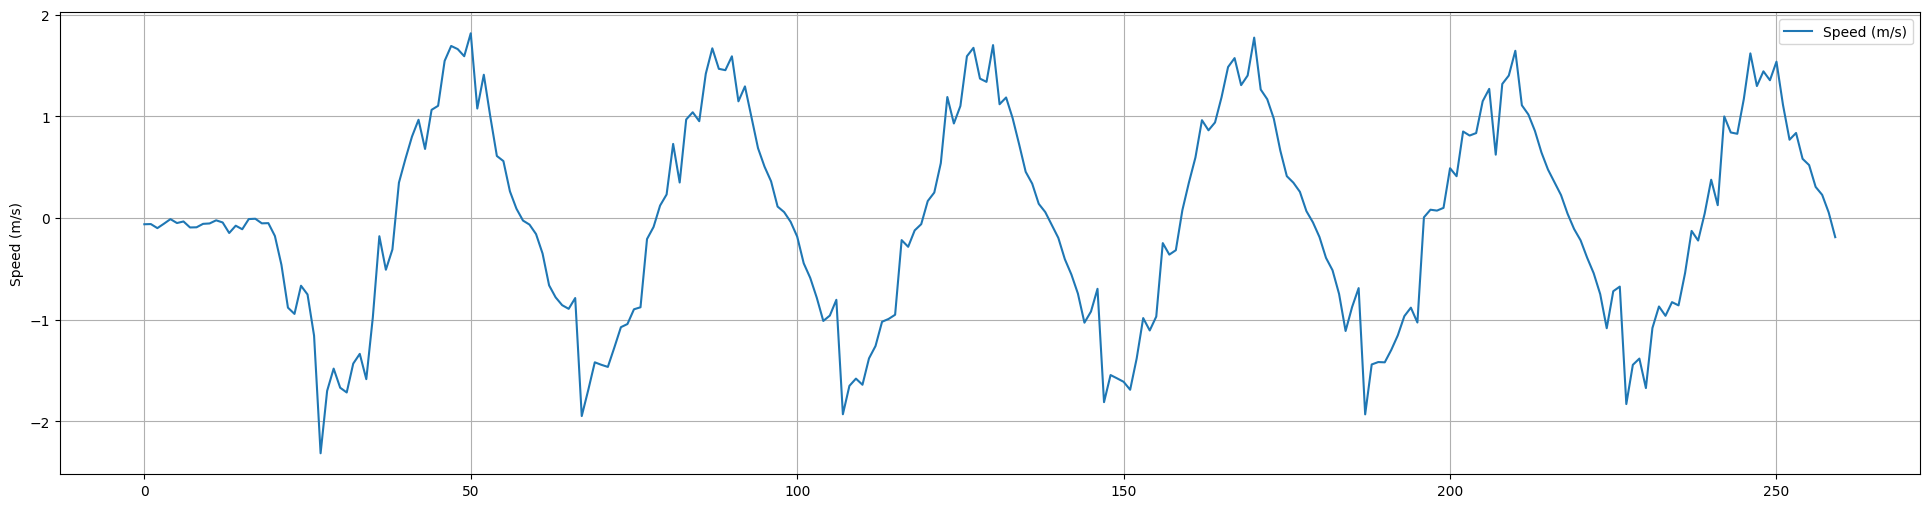

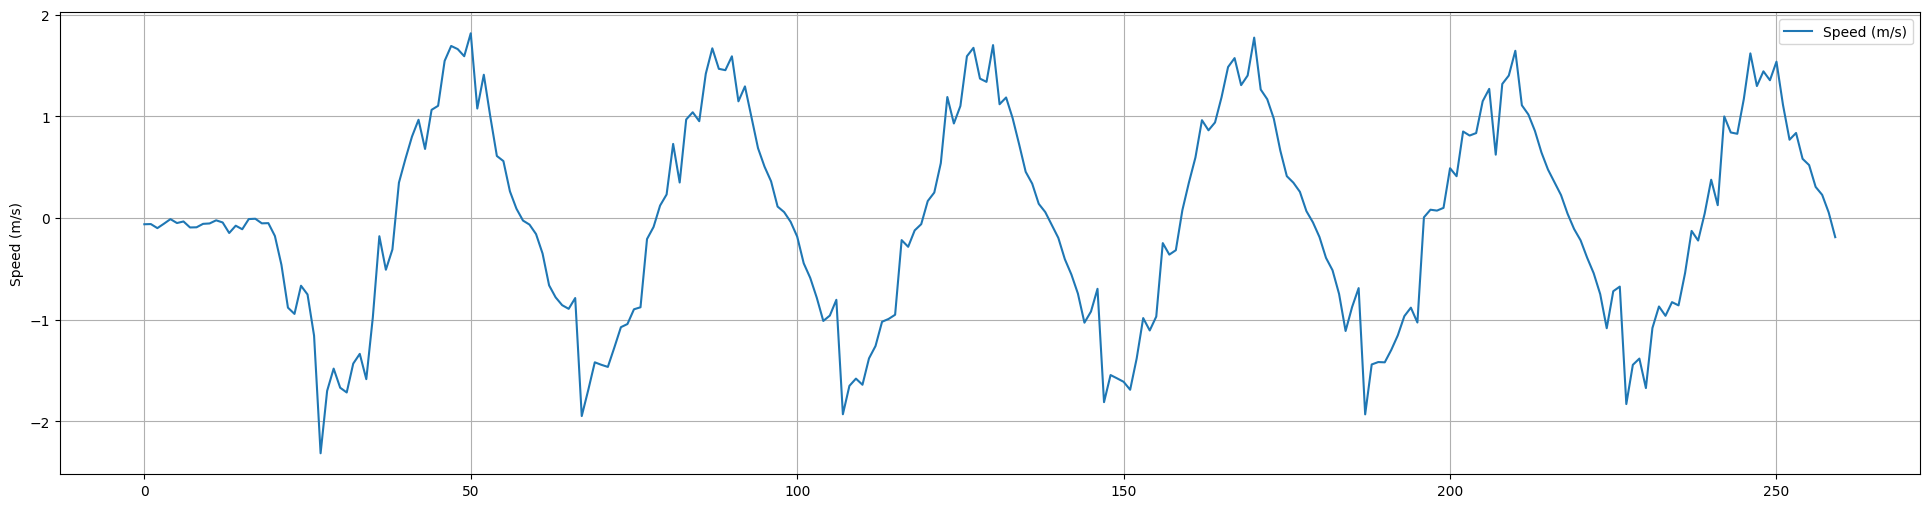

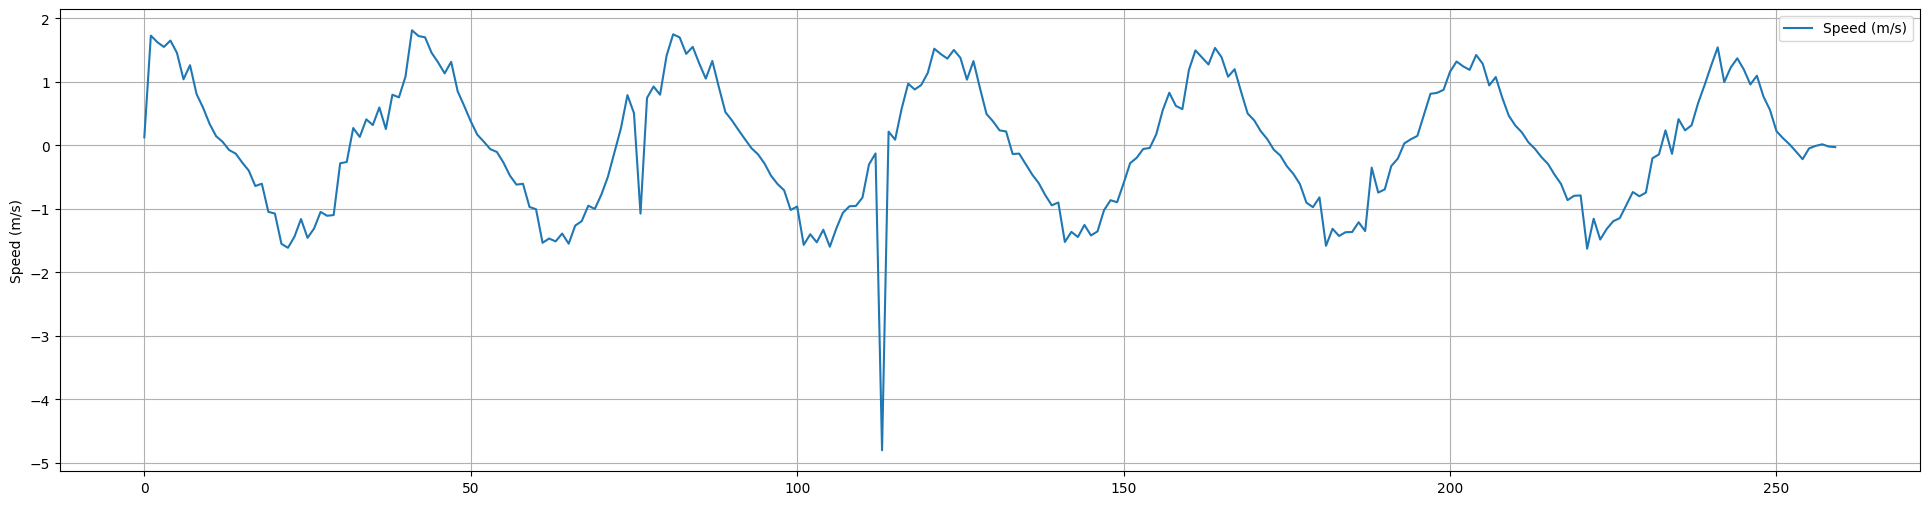

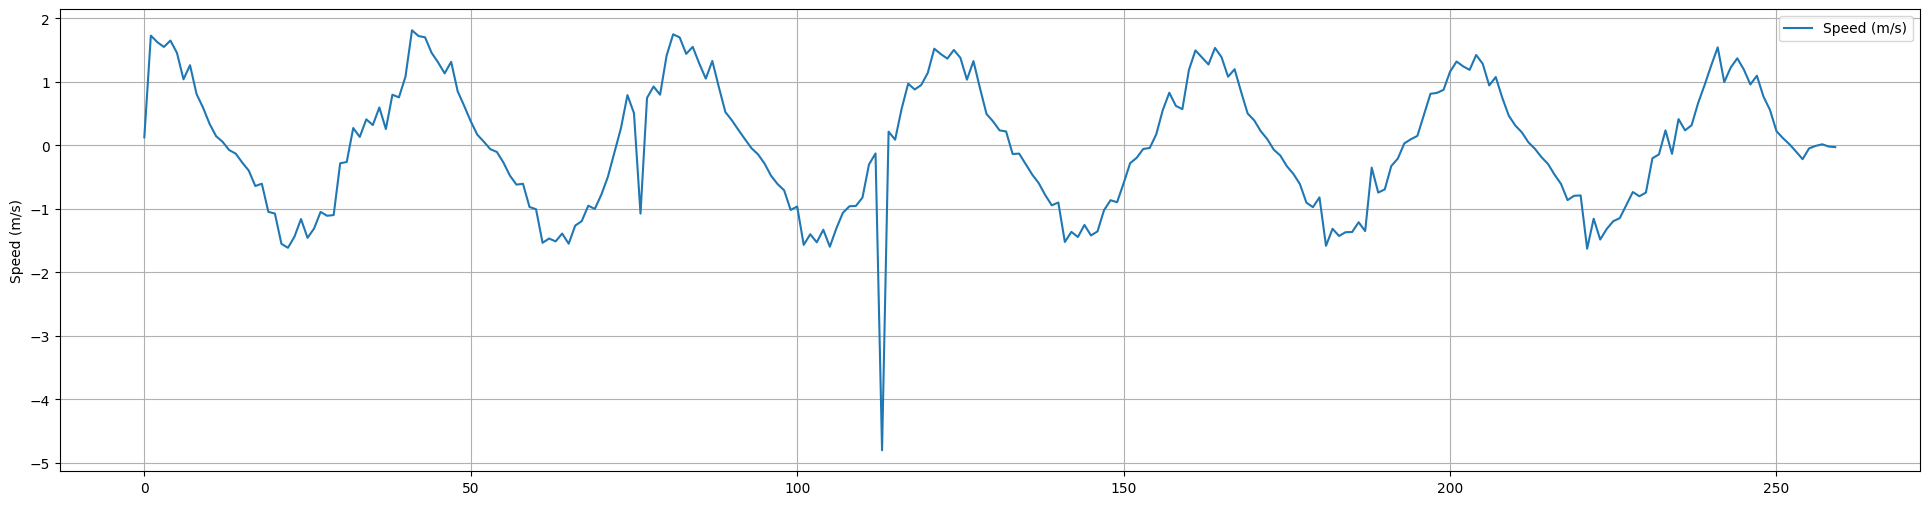

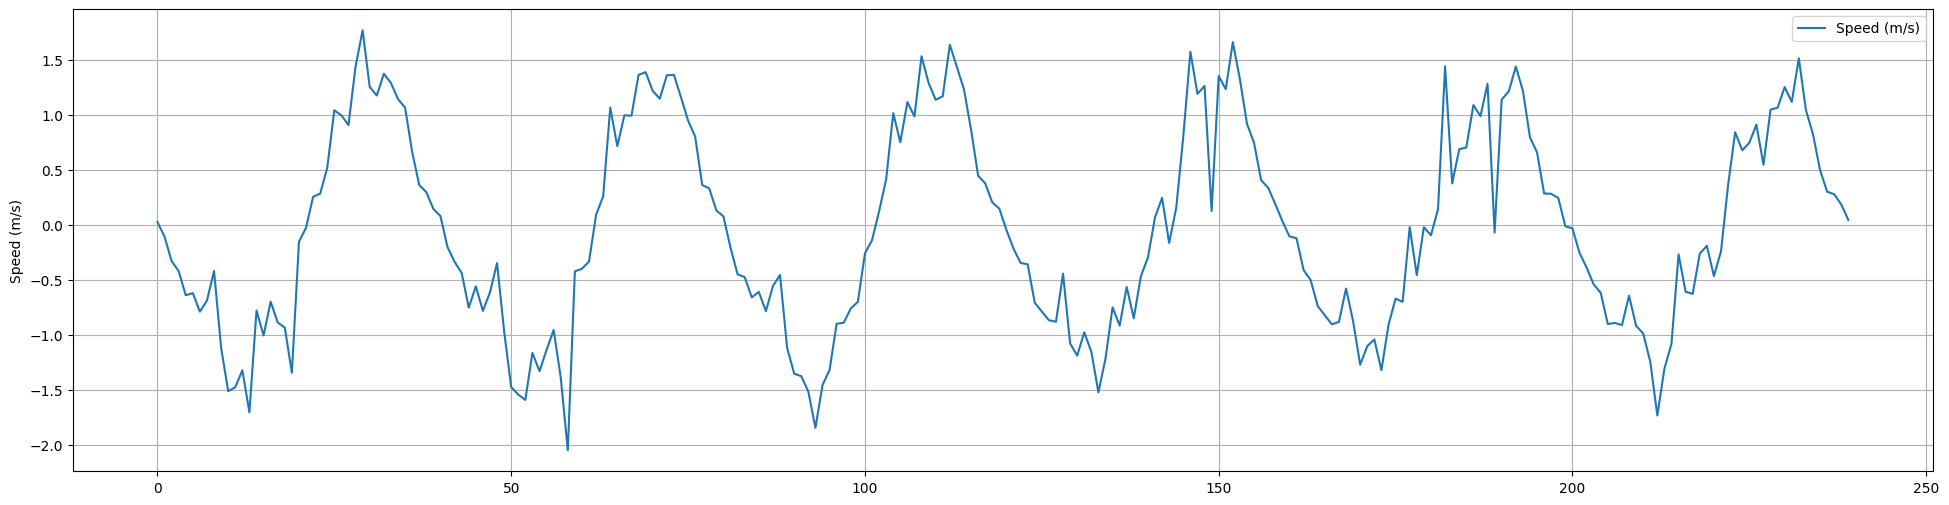

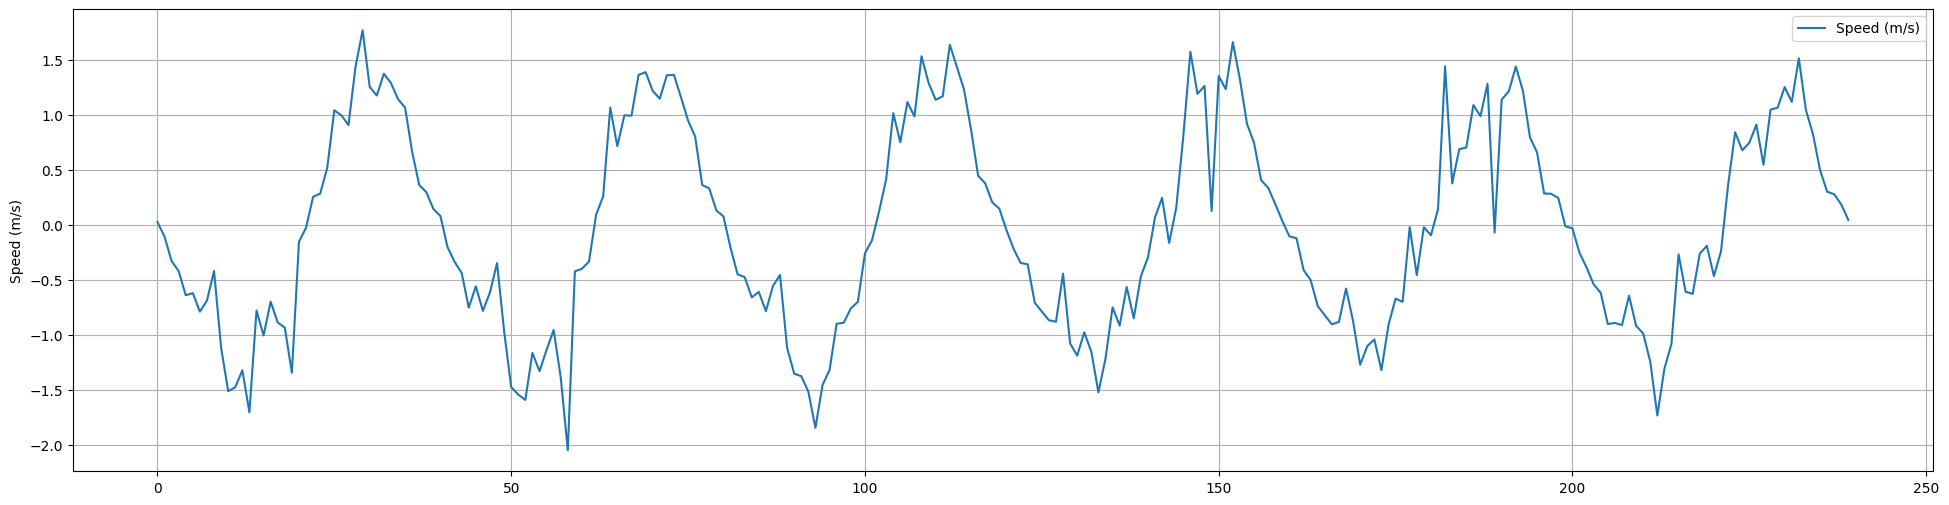

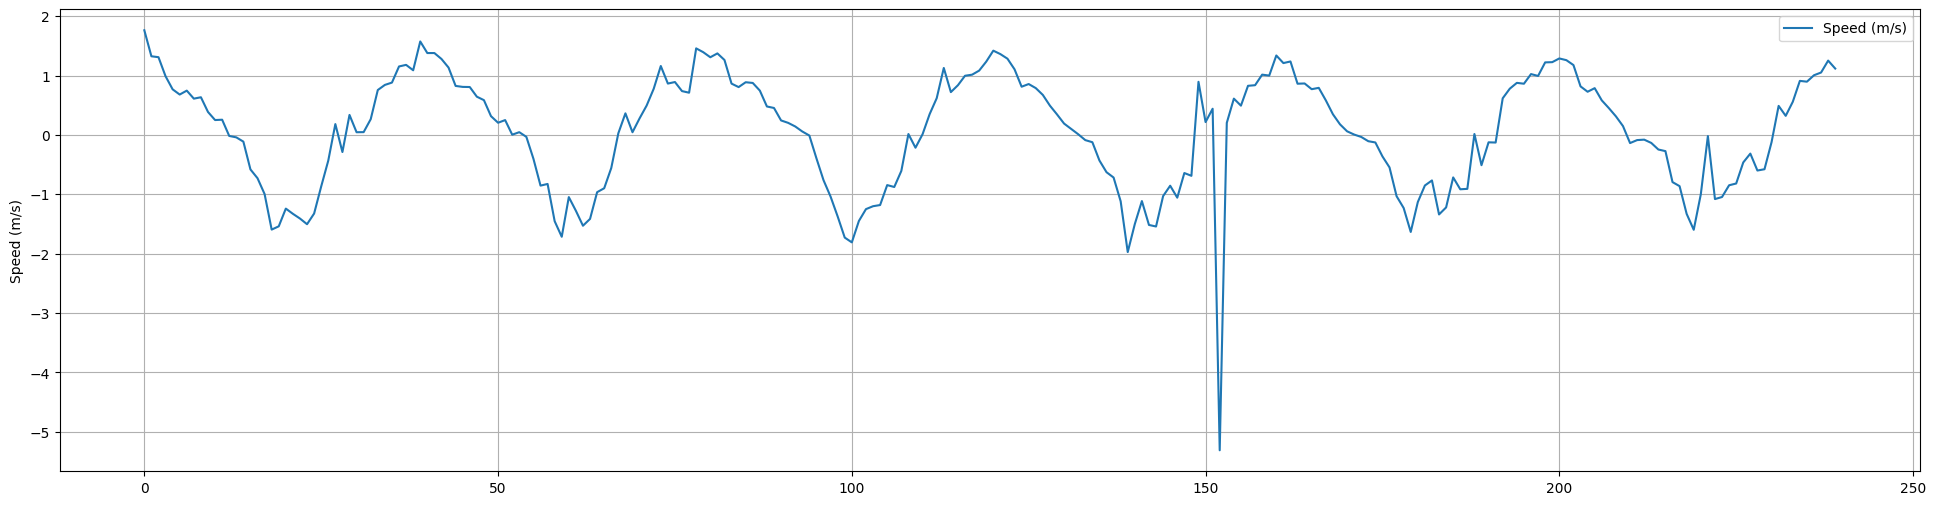

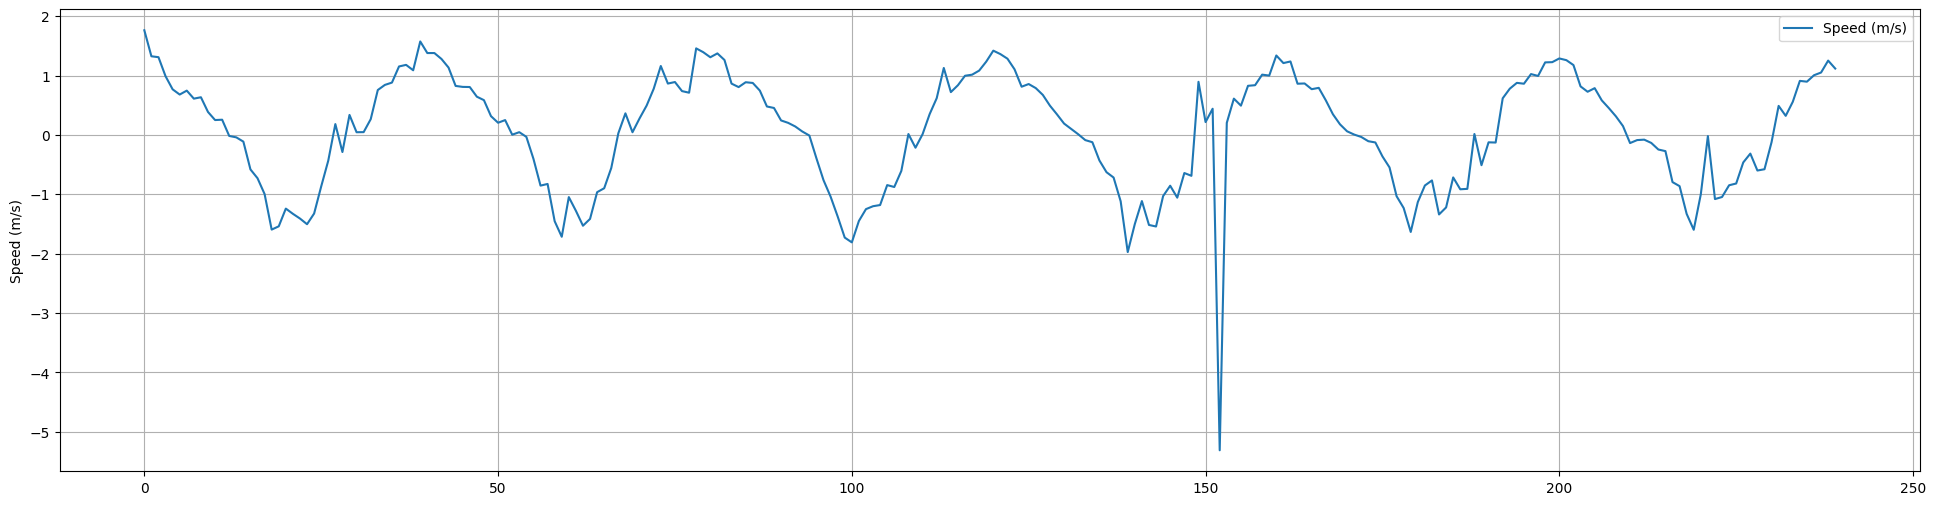

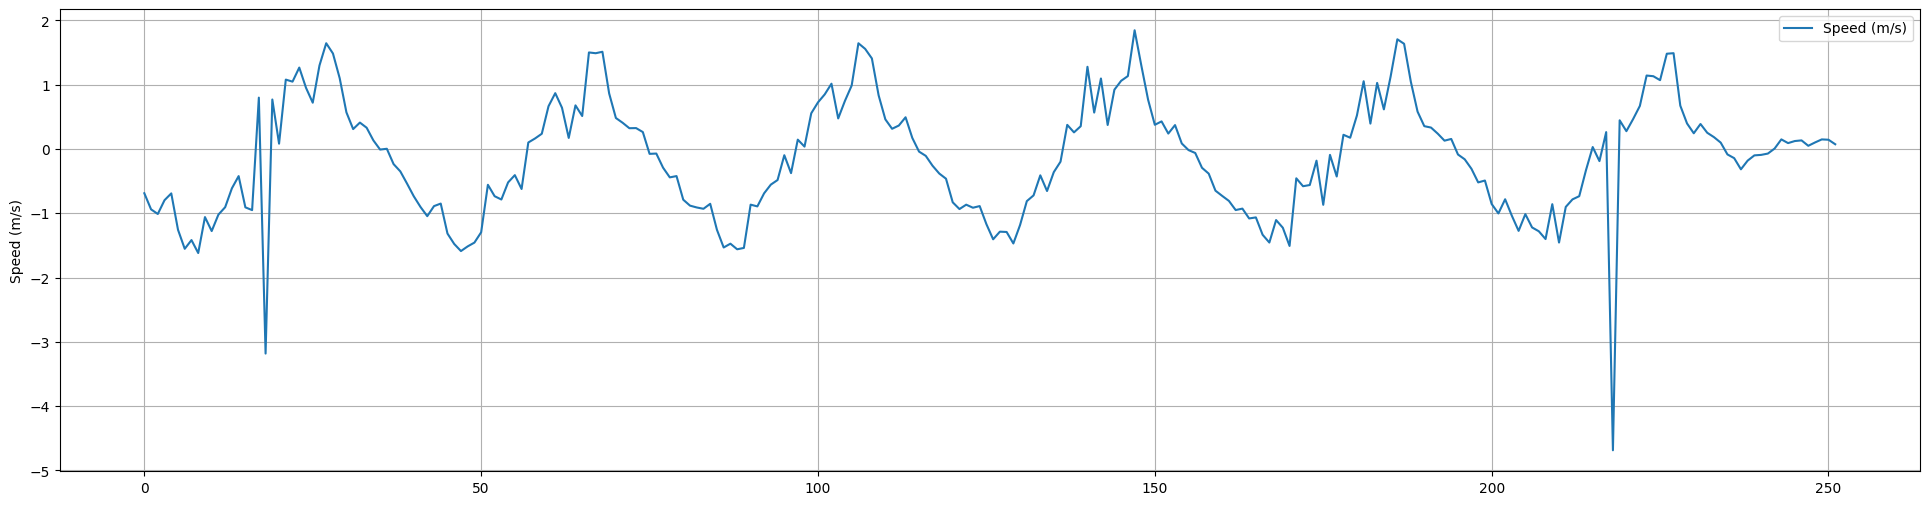

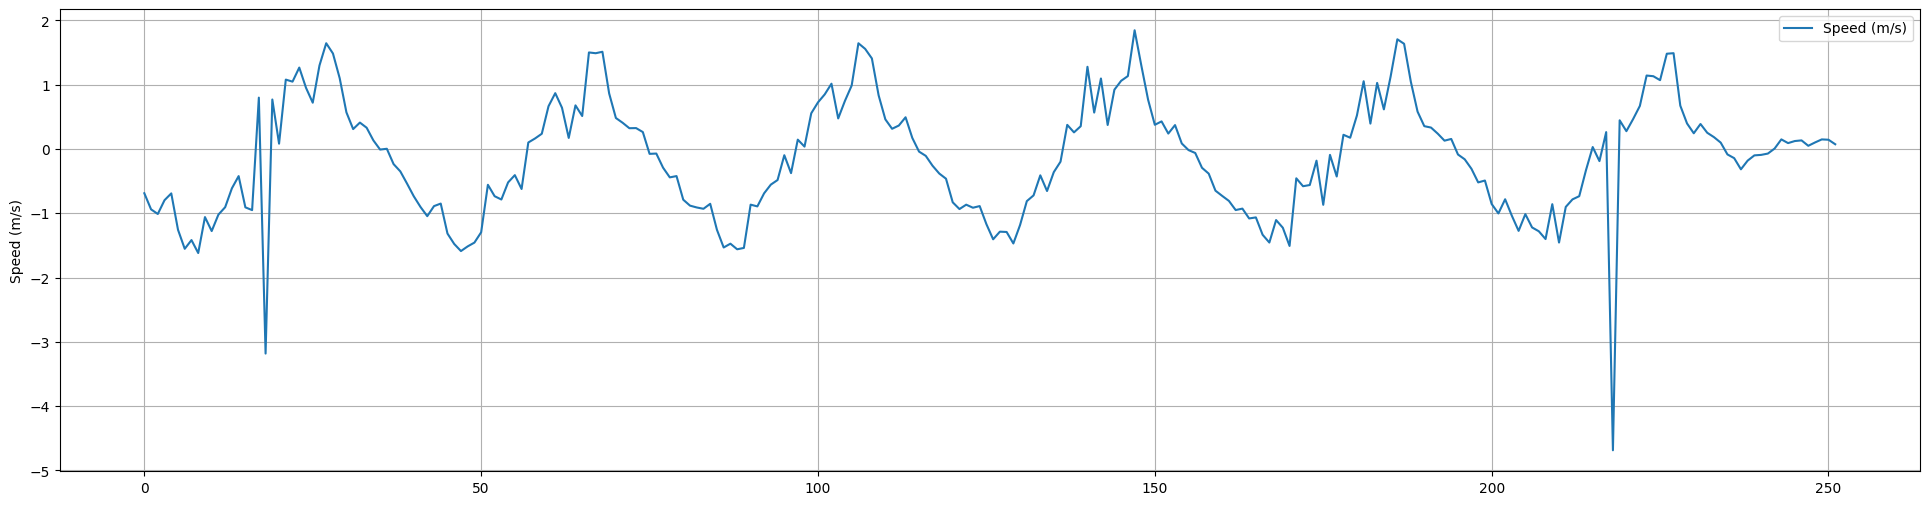

In [20]:
run_experimental_computation(THIRTY_DEG_SAMPLES, WFS_THIRTY_DEG, '30deg')

## 35

In [21]:
THIRTYFIVE_DEG_SAMPLES = read_in_trials(35)

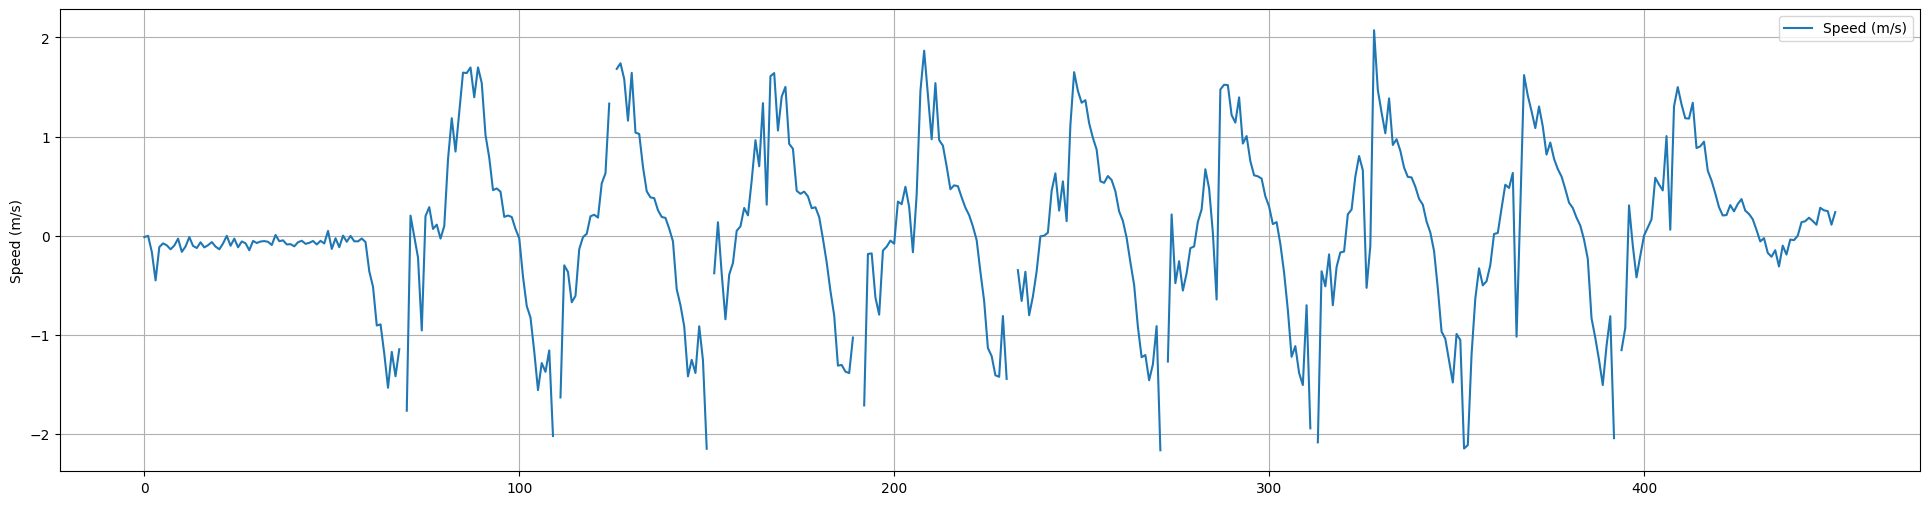

In [22]:
plot_trial_dataframe(THIRTYFIVE_DEG_SAMPLES['35-t10'])

In [23]:
WFS_THIRTYFIVE_DEG = {}

In [24]:
run_experimental_computation(THIRTYFIVE_DEG_SAMPLES, WFS_THIRTYFIVE_DEG, '35deg')

35-t1
[0.420190767, 0.07431357885, 0.01435733266, 1.742345606, 0.06034529664, 1.935747891, 0.03030341398, 0.8170857411, 1.610630659, 0.7491191285, 1.783732225, 0.5445636046, 1.508448085, 0.4263270453, 1.682202675, 0.06292474178, 0.05743642498, 1.59315662, 0.381201426, 1.483681866, 0.08849872388]
[0.01857605143, -1.704904387, -0.09202420615, -0.3078063282, -1.947119962, -0.2556264439, -1.857628489, -0.4287744092, -0.6179477356, -2.157424189, -0.5967826805, -1.74087571, -1.067239835, -1.852313833, -0.2564375826, -1.667326739, -0.1800292383, -0.07799175653, -1.654827738, -0.3939325315, -0.06195290522]
trial avg v: 1.8310021239
~~~~~~
35-t2
[0.03272207424, 0.07038158496, 0.06417013024, 0.0170062708, 0.1206609011, 0.1042879934, 0.1046946759, 0.02782205759, 0.1778700625, 0.3143104286, 1.883877546, 0.06970376061, 1.674410636, 0.6533905102, 1.699799241, 0.02277660731, 0.01316683268, 1.756204296, 0.3362680743, 1.950530971, 1.819340328, 0.03665891231, 0.5437152948, 1.666323343, 1.606677414, 1.66

([1.8310021239,
  1.9302840789999998,
  nan,
  1.9151222800999996,
  1.8692938447,
  1.9219013449999998,
  1.9297311966,
  1.90032048,
  1.8679829337,
  1.9601814745],
 nan)

## 40

In [25]:
FORTY_DEG_SAMPLES = read_in_trials(40)

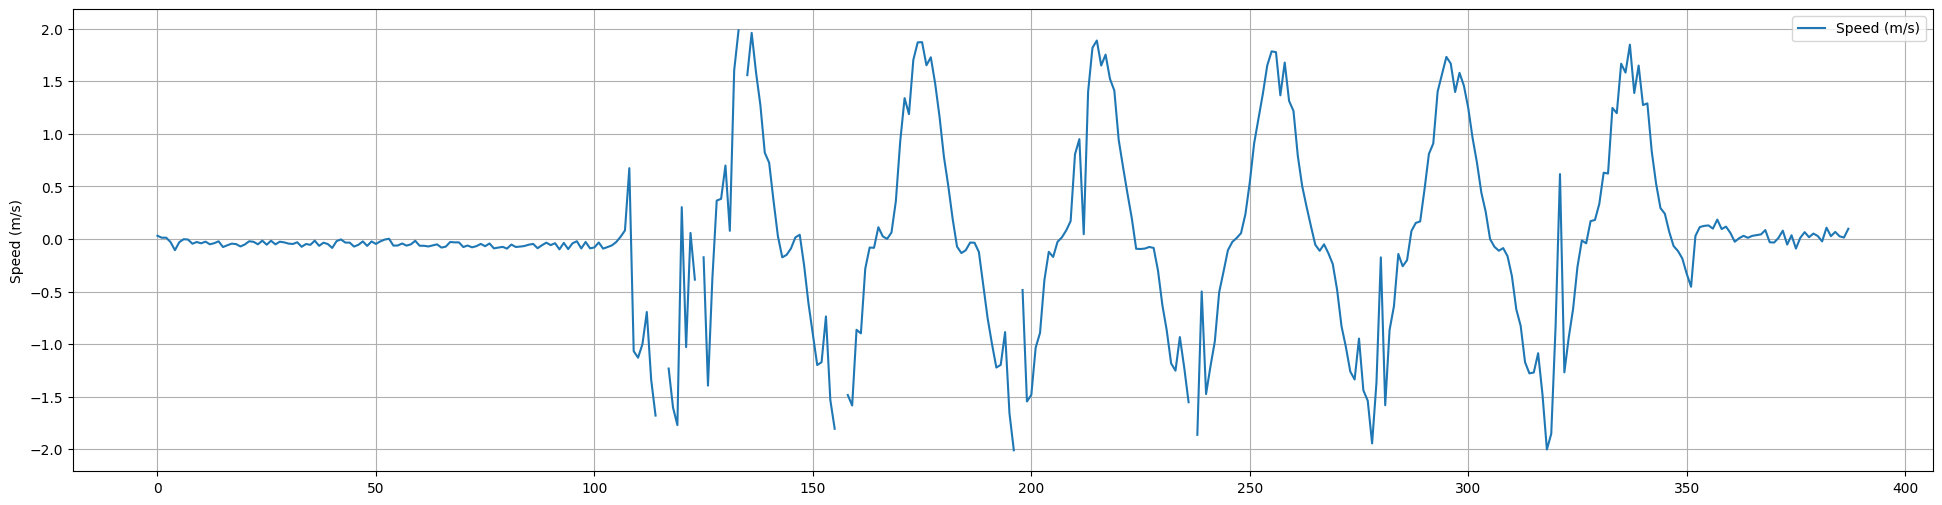

In [26]:
plot_trial_dataframe(FORTY_DEG_SAMPLES['40-t10'])

In [27]:
WFS_FORTY_DEG = {}

In [28]:
run_experimental_computation(FORTY_DEG_SAMPLES, WFS_FORTY_DEG, '40deg')

40-t1
[0.04591274817, 0.01016924773, 0.01895087127, 0.02594526125, 0.01879093982, 0.1974549916, 2.118720973, 0.6462568084, 0.1104030125, 0.2520746246, 2.044128657, 0.2228056498, 0.137486673, 2.114656655, 1.954050724, 1.984938677, 1.881053765, 0.04242420201, 1.735359022, 1.665041091, 1.640941632, 0.05838426509]
[-0.3875082944, -0.1700770625, -0.1031797256, -0.1329183036, -0.0169757444, -2.045628781, -1.328748087, -0.1643534202, -1.60336303, -0.07119132902, -0.3677310478, -1.937113072, -0.2448904109, -0.06220559856, -1.864389568, -2.005953768, -1.869039482, -1.798608159, -0.08180365614, -1.789691429, -1.873246627, -0.08393595806]
trial avg v: 1.9947477416000001
~~~~~~
40-t2
[0.2004783683, 0.0565358012, 0.009307036604, 0.01051251543, 0.06737292988, 0.05202676546, 0.009203923108, 0.01745547208, 0.01204690266, 0.1067918771, 0.04216567872, 0.04256154465, 0.0730925534, 0.04287301278, 0.8375247851, 2.012092505, 0.7668567863, 0.1473798551, 2.111019142, 0.05828780759, 2.041829119, 0.07218387699,

([1.9947477416000001,
  2.0120387347,
  2.0655249430000002,
  2.0076368659,
  2.0953924445,
  2.087795891,
  2.0523192994999997,
  2.0632605391999994,
  2.0214536931,
  1.9003738935999999],
 0.05424421513033188)

## 45

In [29]:
FORTYFIVE_DEG_SAMPLES = read_in_trials(45)

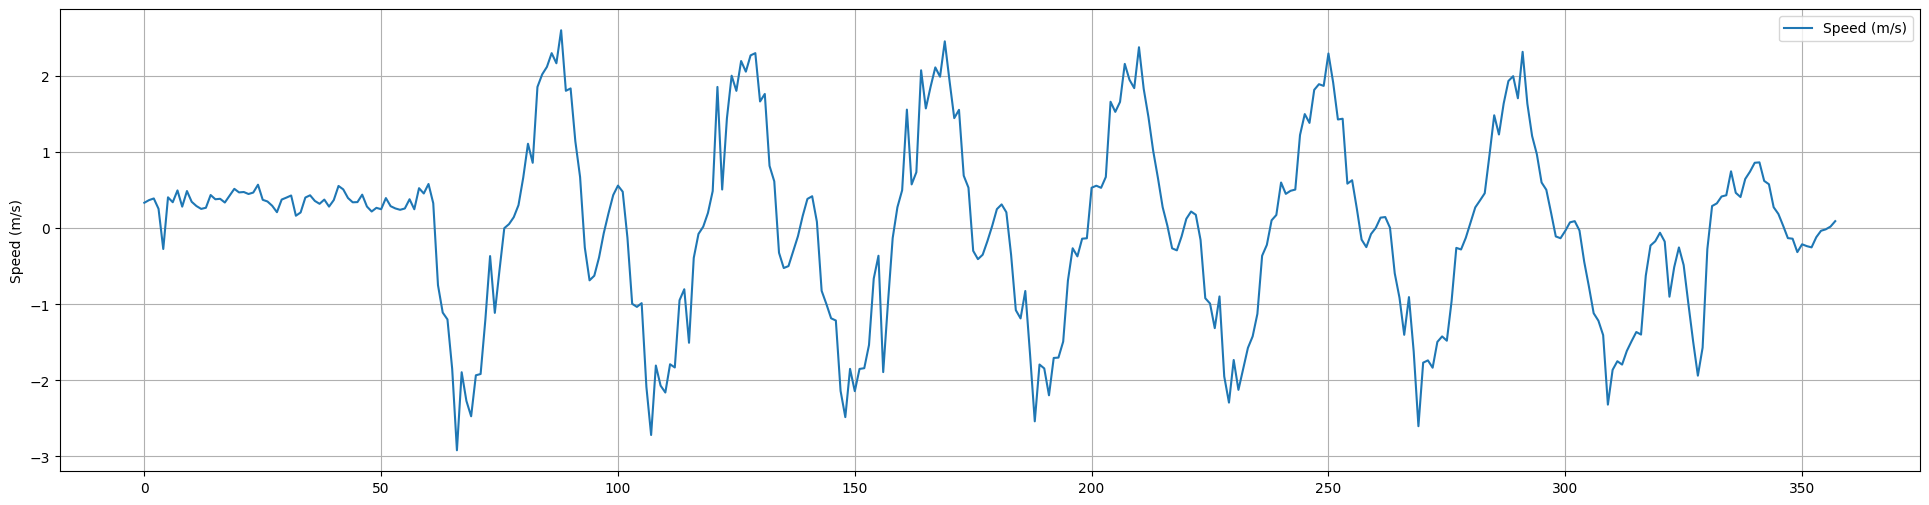

In [30]:
plot_trial_dataframe(FORTYFIVE_DEG_SAMPLES['45-t10'])

In [31]:
WFS_FORTYFIVE_DEG = {
    '45-t1': WaveFilter(x_min=7.5),
    '45-t2': WaveFilter(x_min=13, x_max=25),
    '45-t3': WaveFilter(x_min=7, x_max=17),
    '45-t4': WaveFilter(y_min=-4),
    '45-t5': WaveFilter(x_min=4),
    '45-t6': WaveFilter(x_min=10, x_max=22),
    '45-t7': WaveFilter(x_min=10, y_min=-4),
    '45-t8': WaveFilter(x_min=15),
    '45-t9': WaveFilter(x_min=7.5),
}

45-t1
[2.35028930282949, 0.587686592335759, 2.33935199632946, 0.624743409471134, 2.30179931371359, 0.593980256695321, 2.19159202888688, 2.07514322458236]
[0.968199136222867, -0.60108033049211, -2.48783094100234, -0.454793806798182, -2.48187104593304, -0.221925845587942, -2.71493727545491, -2.41665974524254]
trial avg v: 2.232767401019748
~~~~~~
45-t2
[2.05587629790206, 0.364045968175644, 1.99998155737188, 1.92152083343621, 1.8594893217682, 1.7383391153665, 0.077041535989224, 0.0279491063884962, 0.0412913733056919]
[-2.21417310275484, -0.261585205598021, -2.02456732195313, -2.49037897780444, -2.16113157749768, -2.44847405290193, -0.251856468156246, -0.14138036435781, -0.0137293778452285]
trial avg v: 2.091393215875687
~~~~~~
45-t3
[2.31036993231666, 0.612793674608745, 0.0645588349356063, 2.24116203217038, 0.505455493961939, 0.0904378151415153, 2.21681142840729, 0.390675608435014, 0.0687022320186892, 2.01490448720292, 0.18126800340345, 2.15972620887235]
[-0.0292588455364573, -0.567278997

([2.232767401019748,
  2.091393215875687,
  2.015588191941064,
  2.375170964665375,
  2.3563442463395665,
  2.33419146690518,
  2.2543410420469137,
  1.9769676508707552,
  2.3297782678737455,
  2.5311806051731702],
 0.16566808293646776)

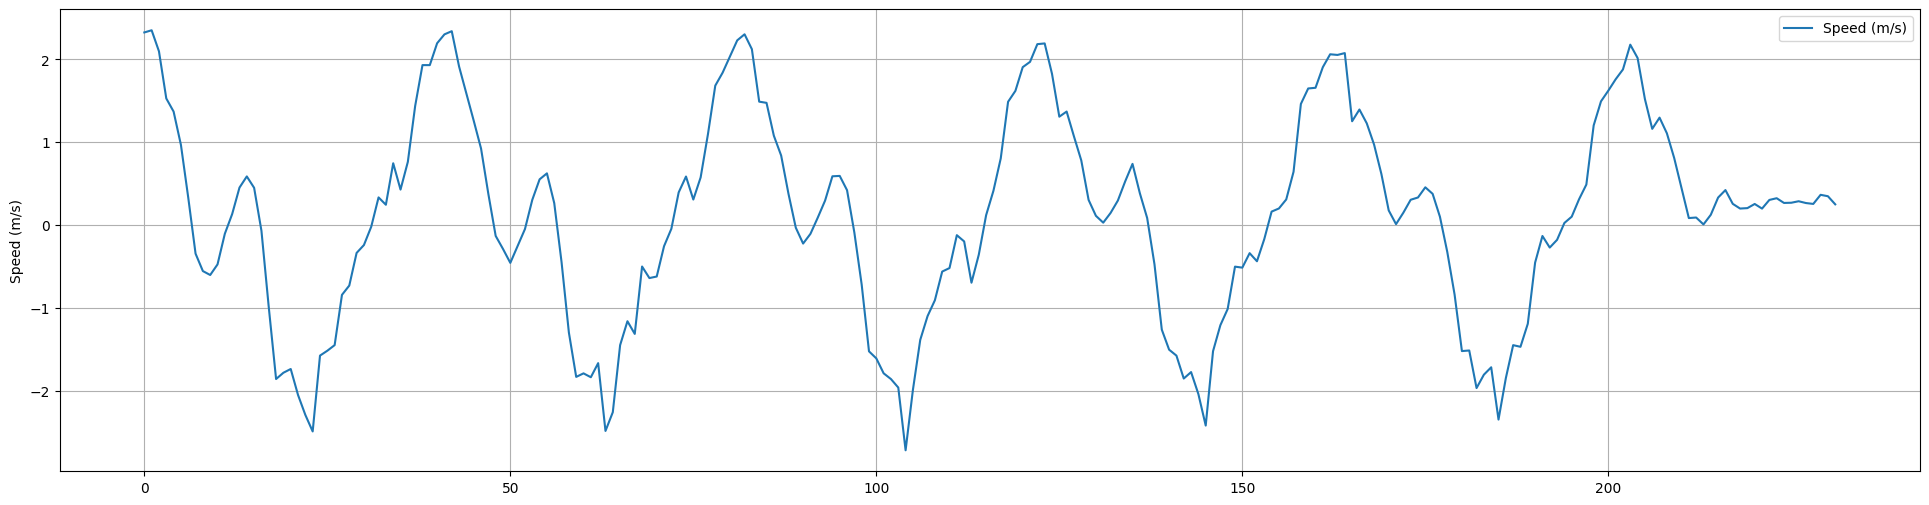

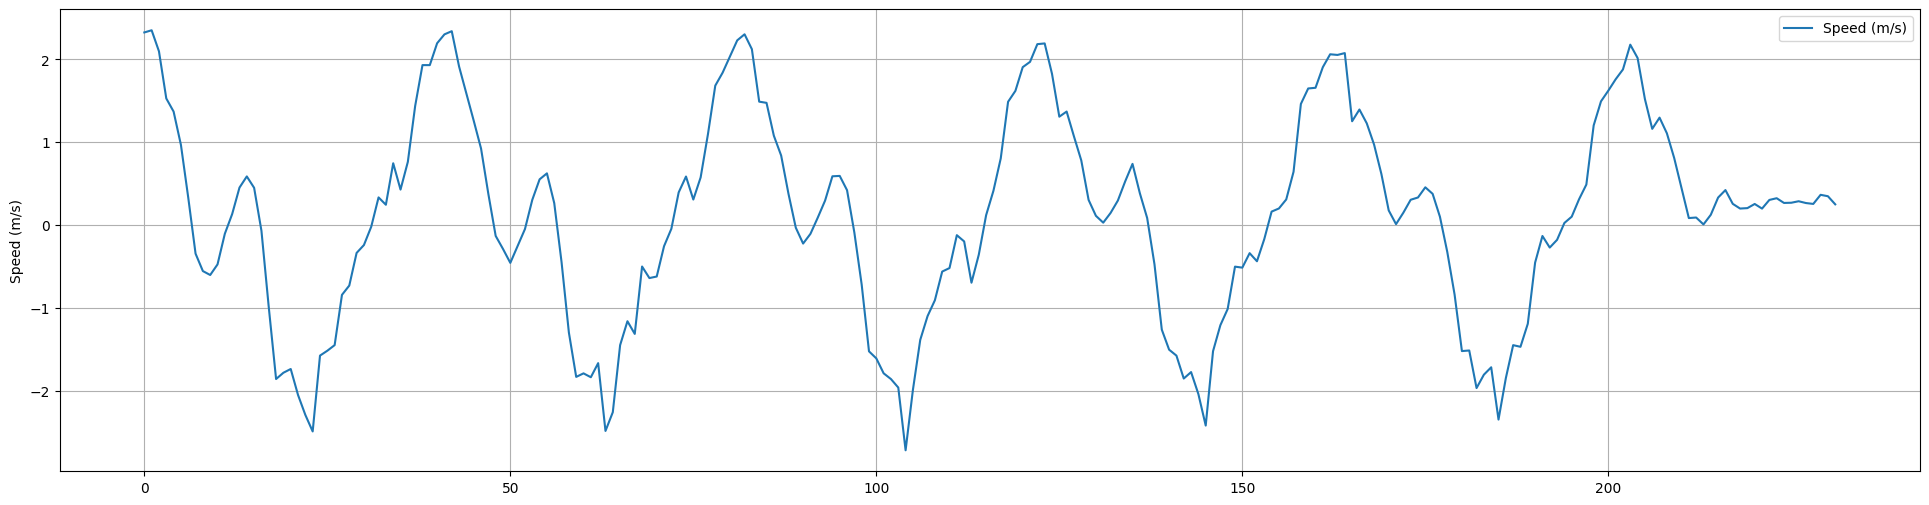

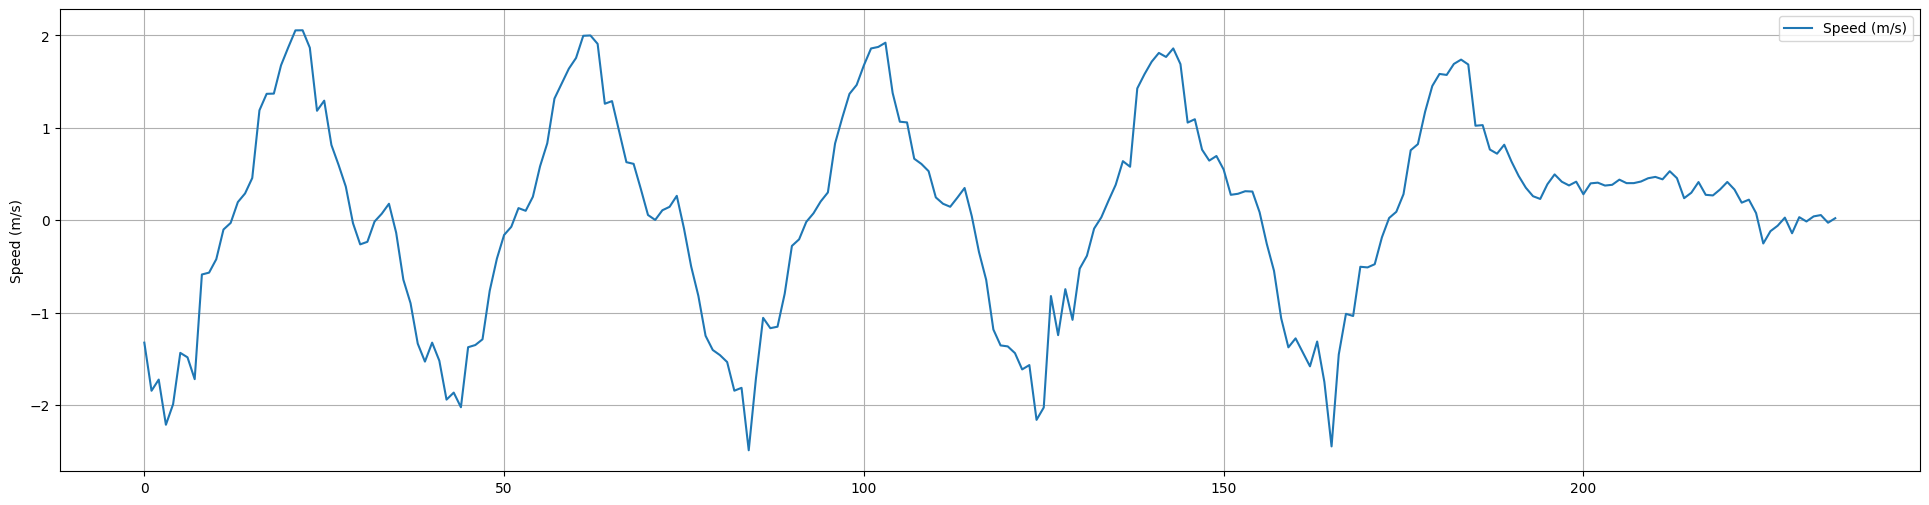

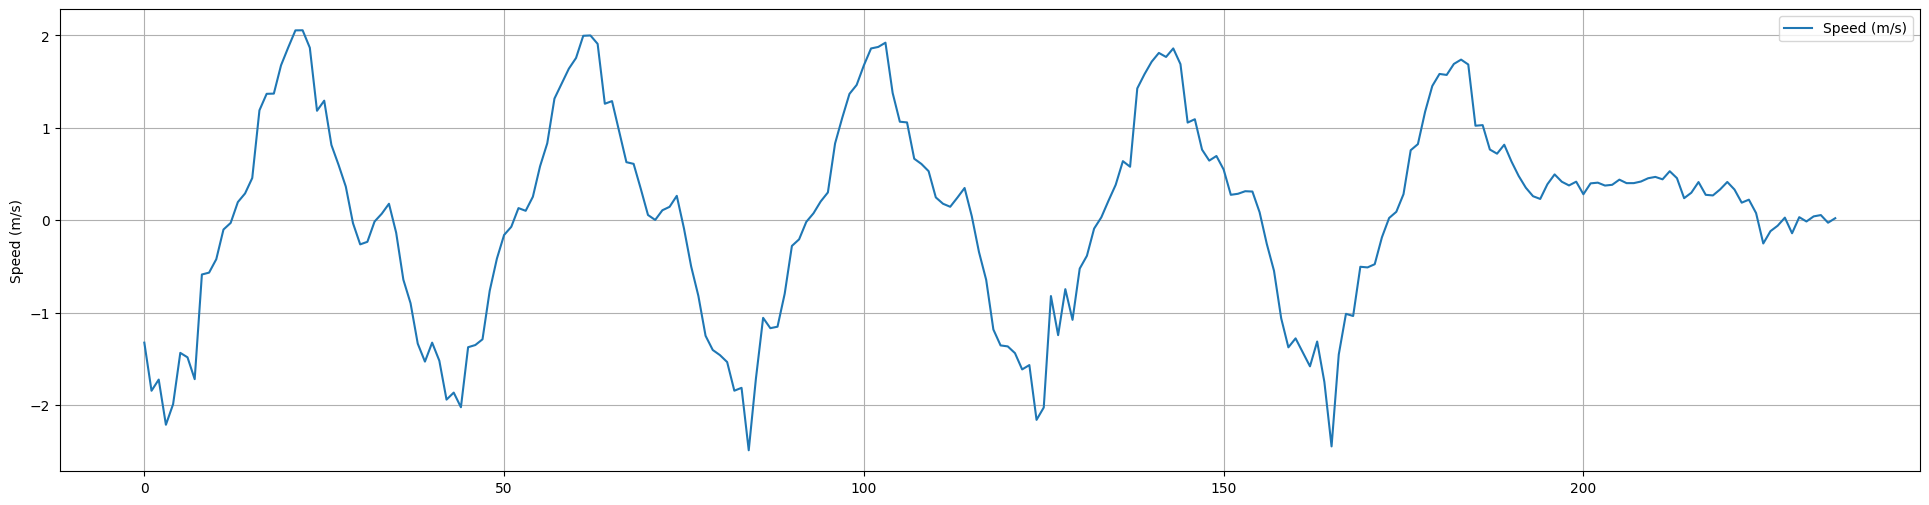

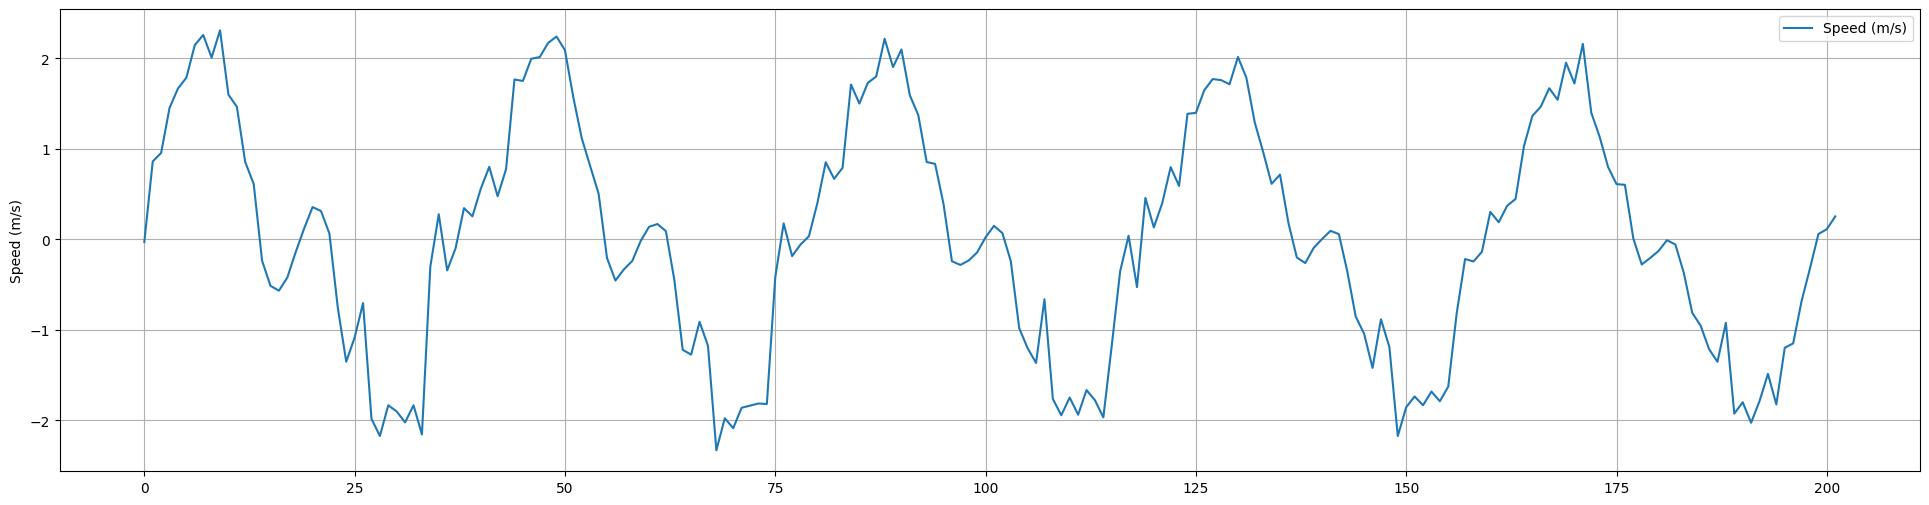

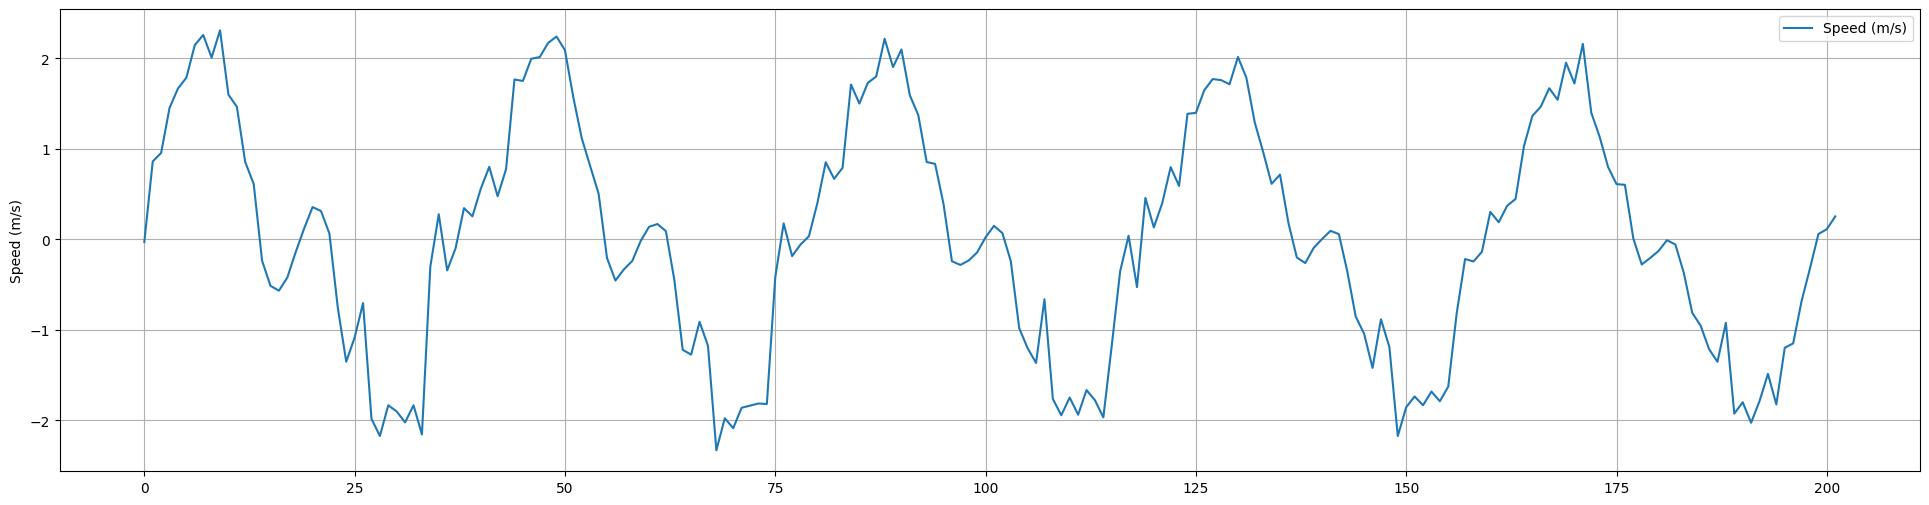

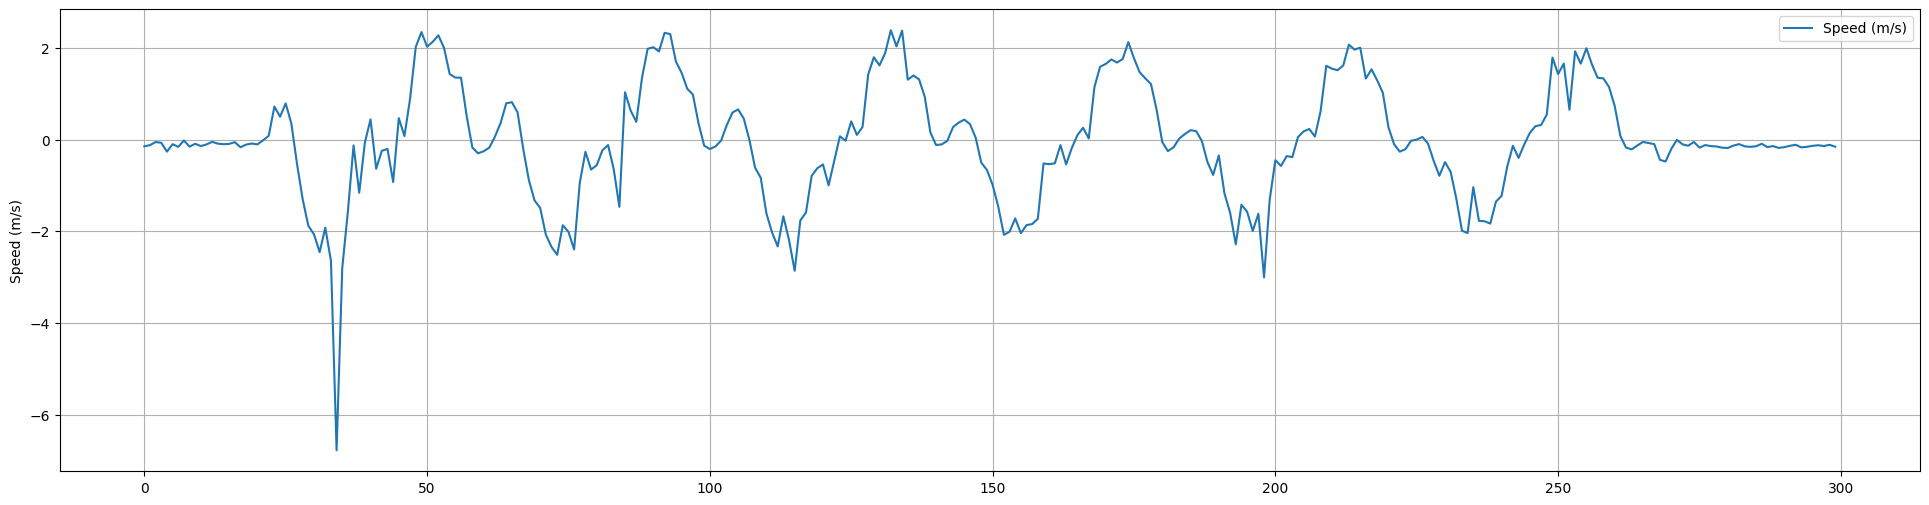

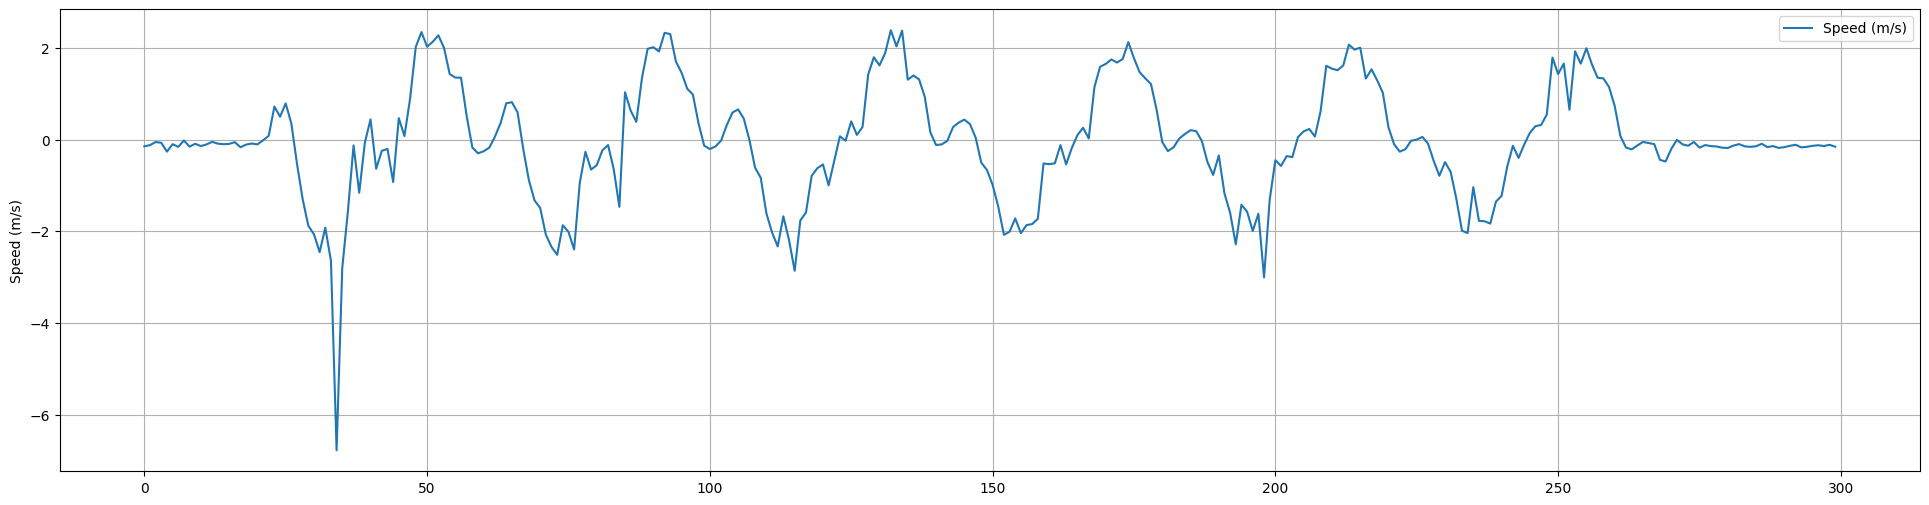

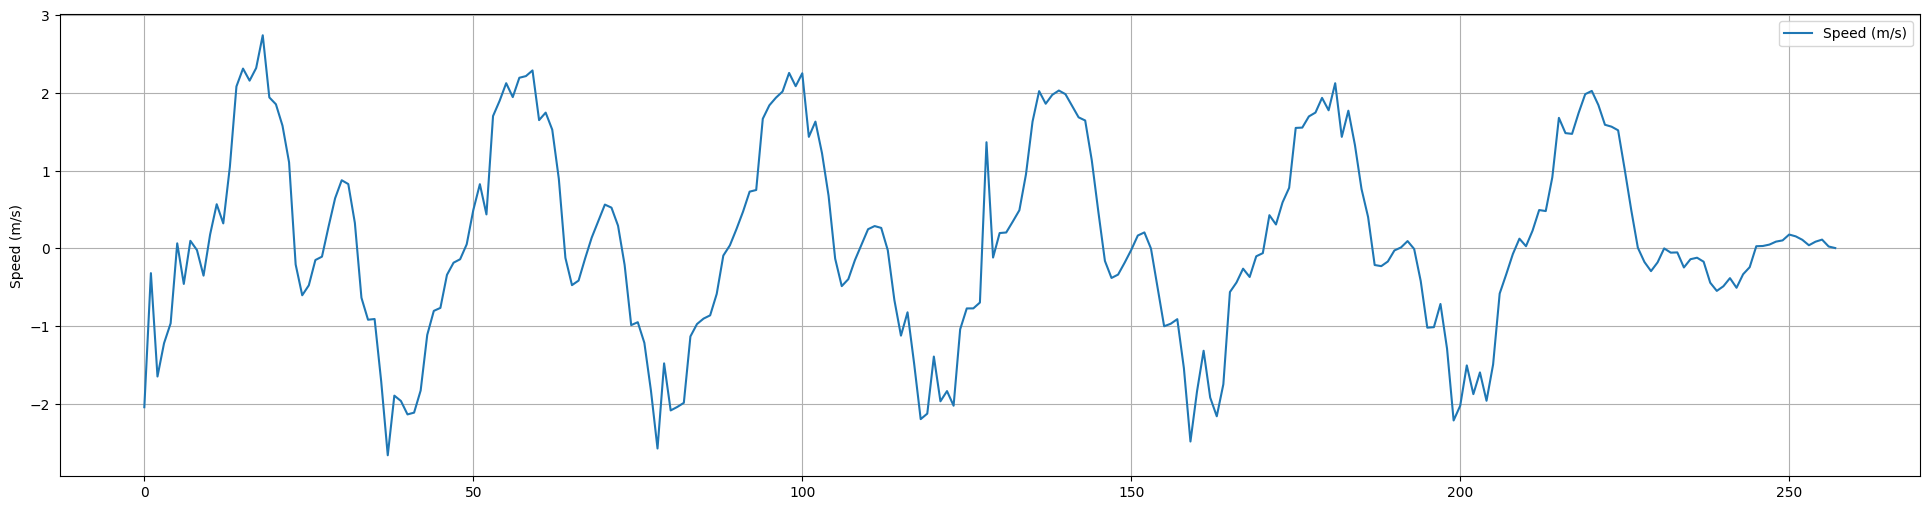

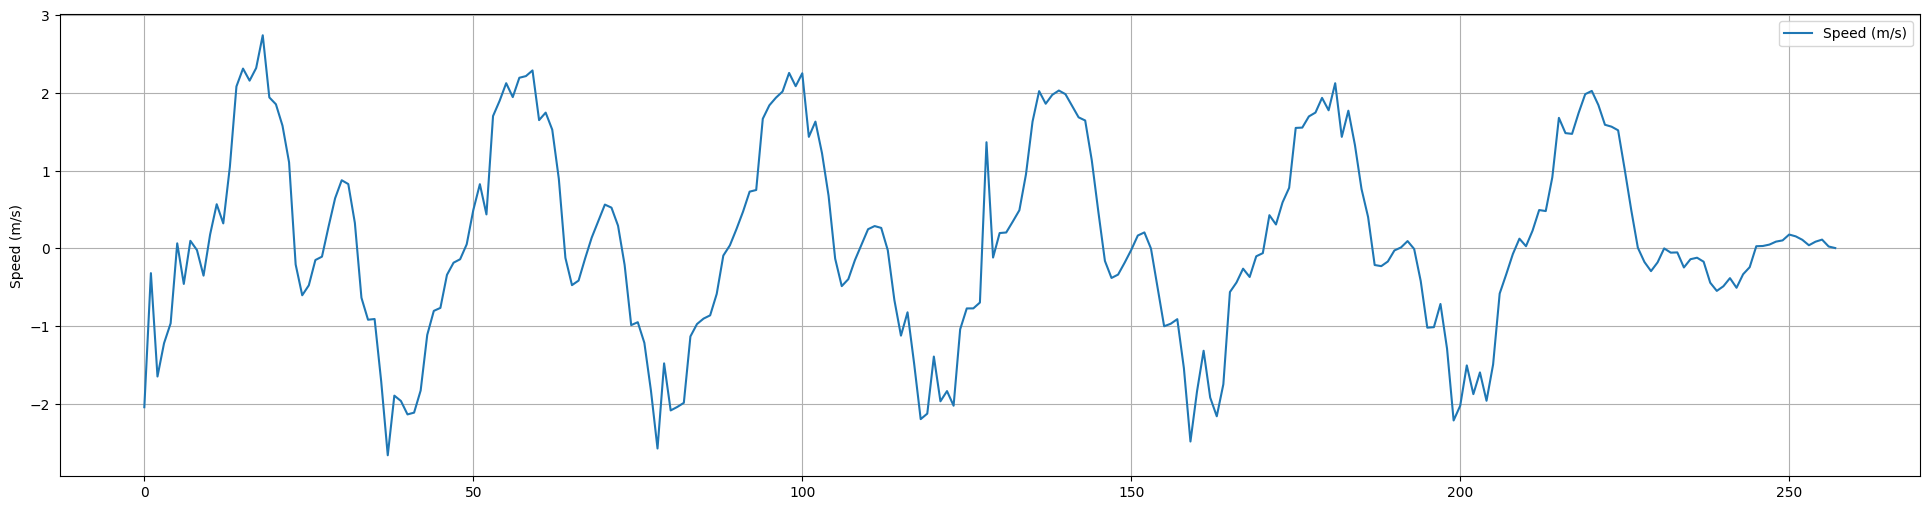

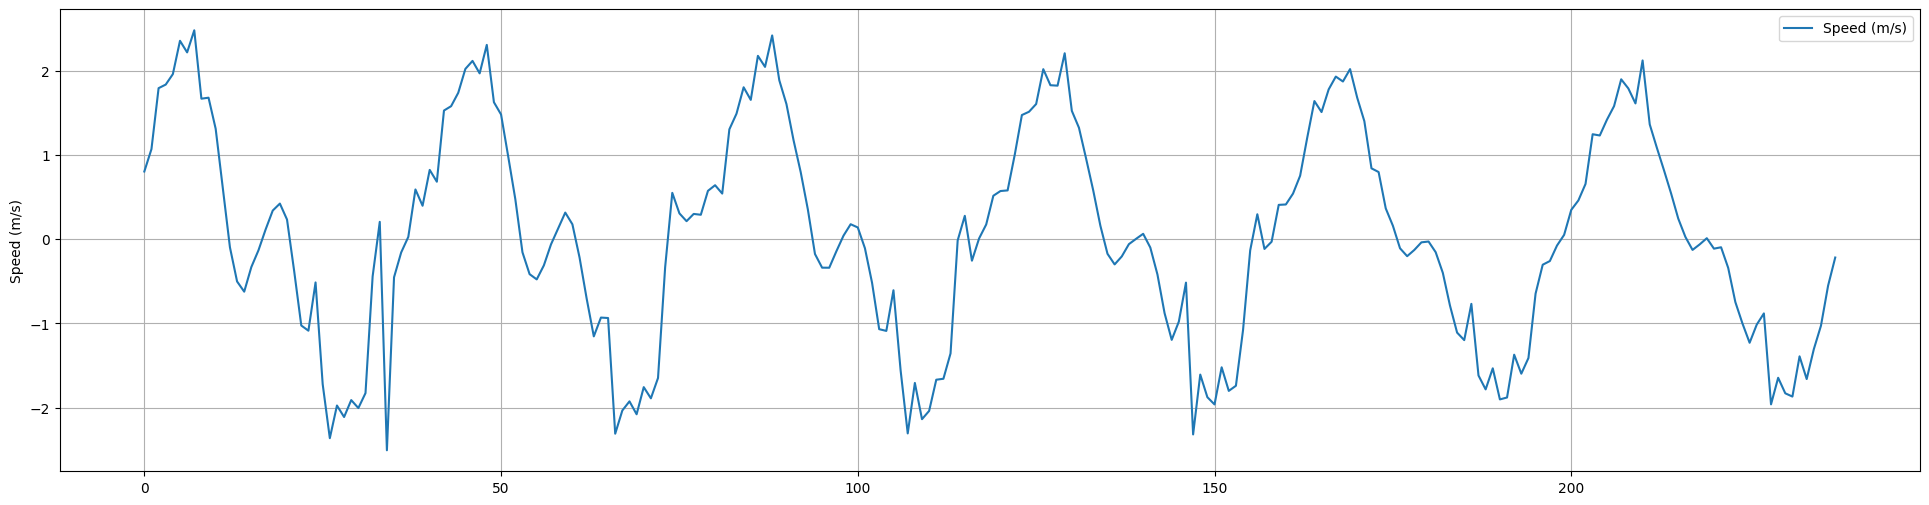

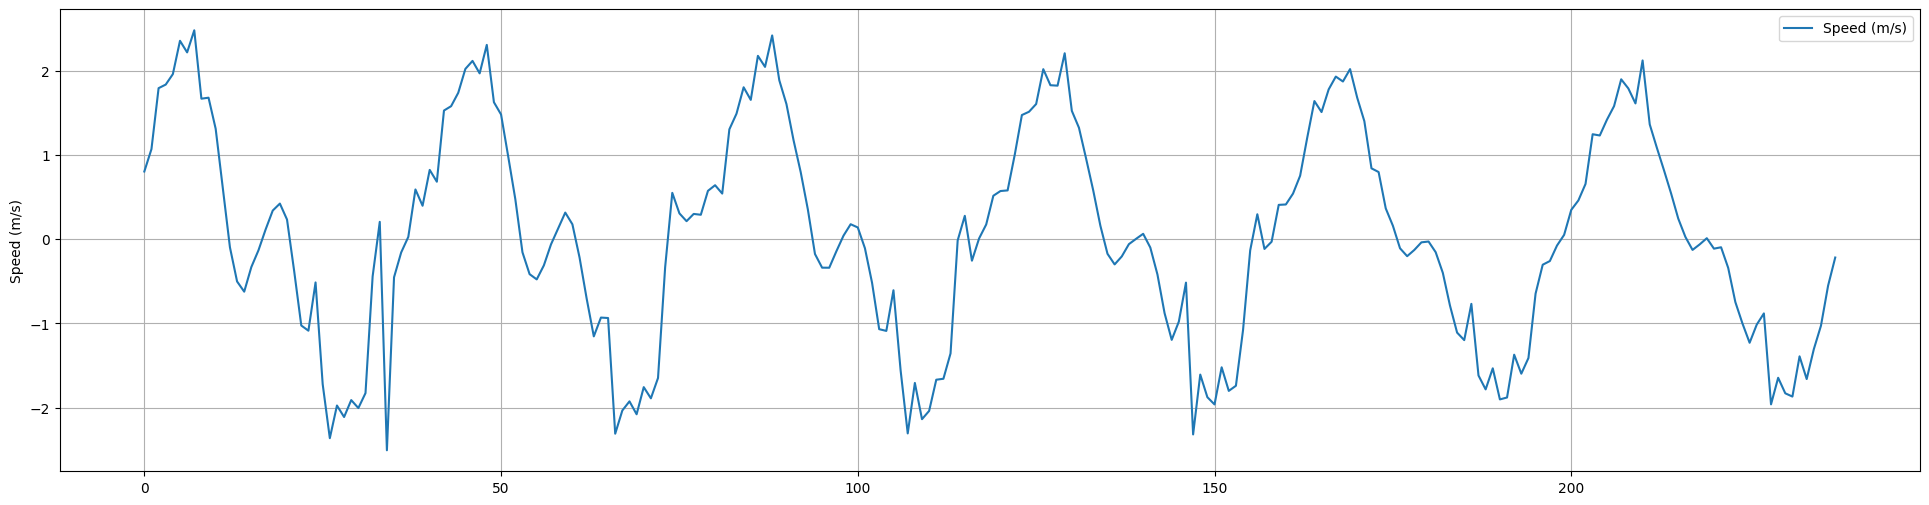

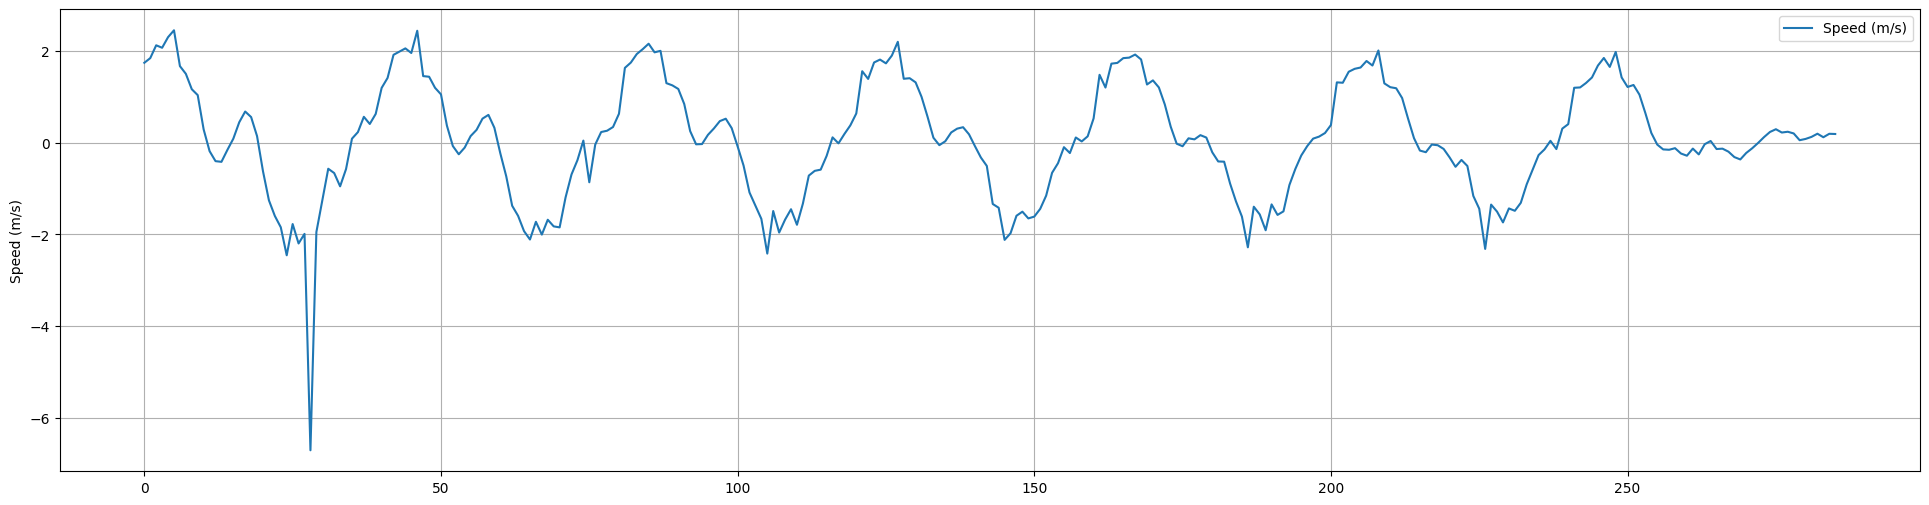

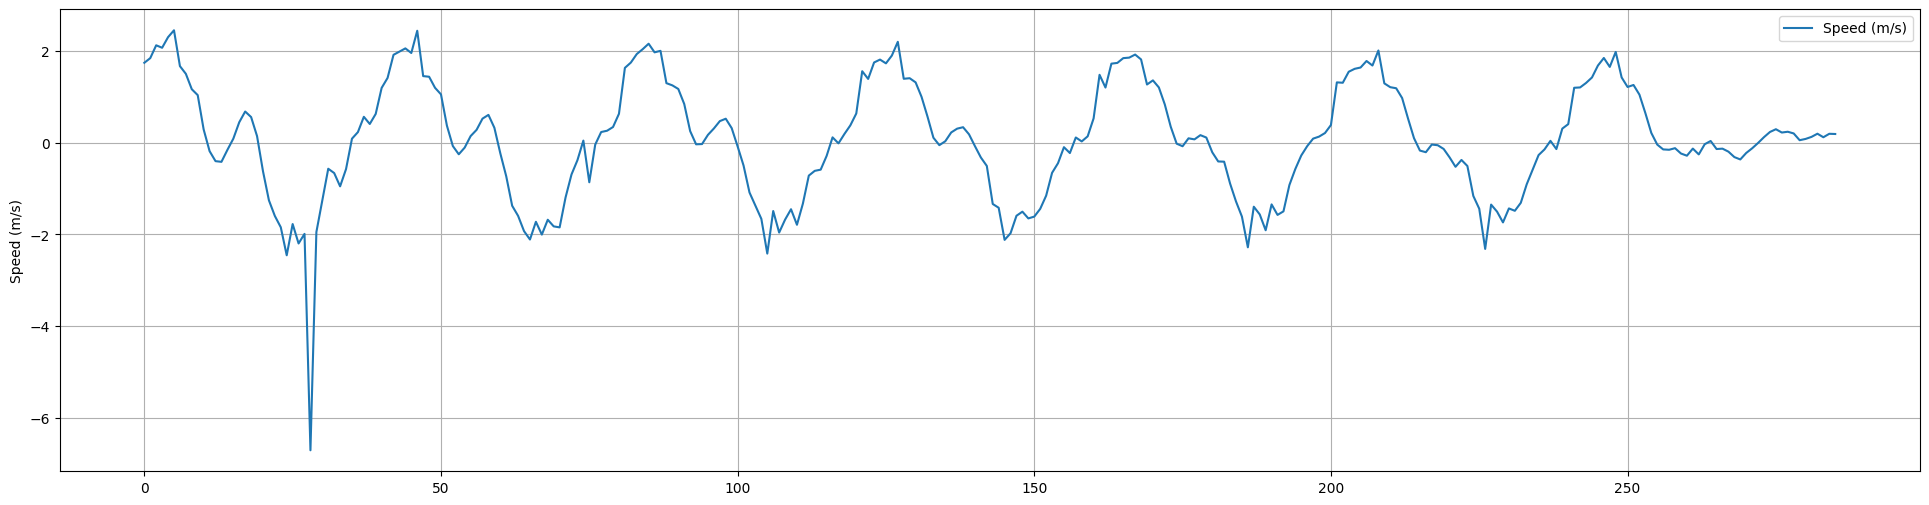

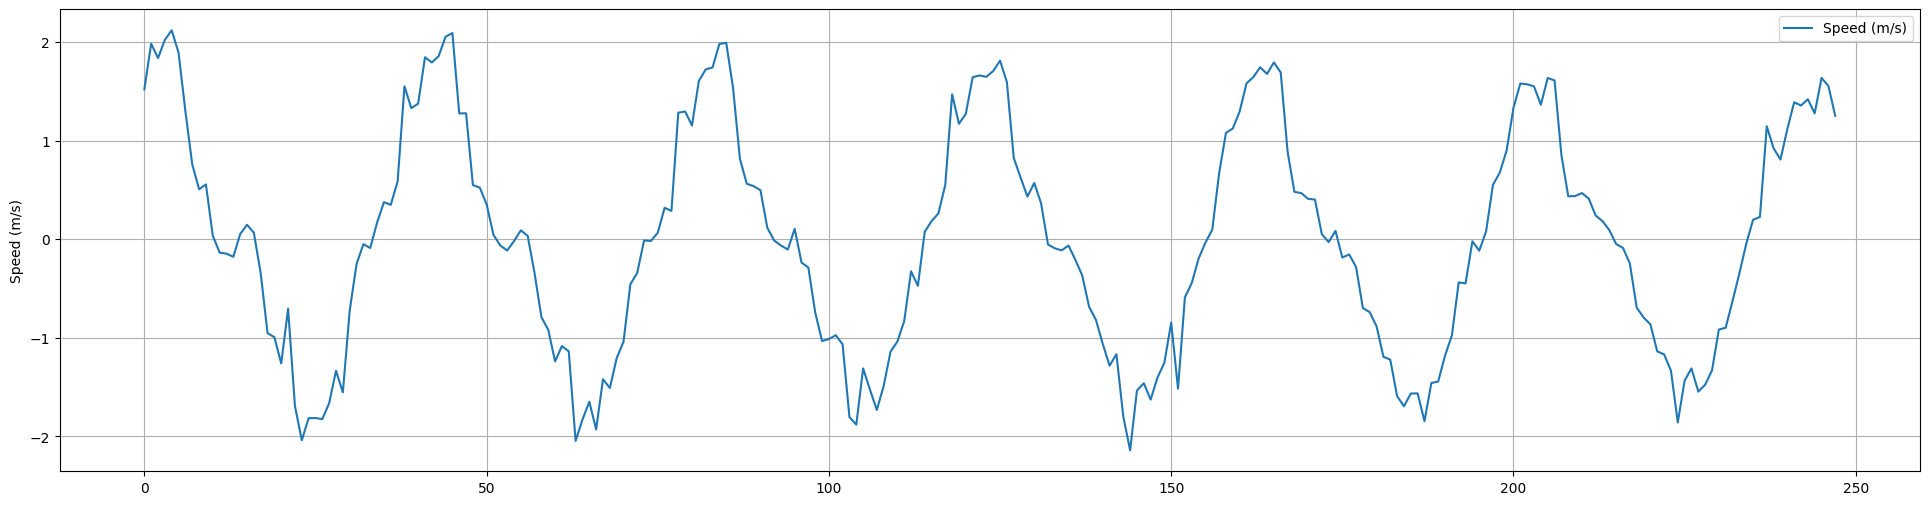

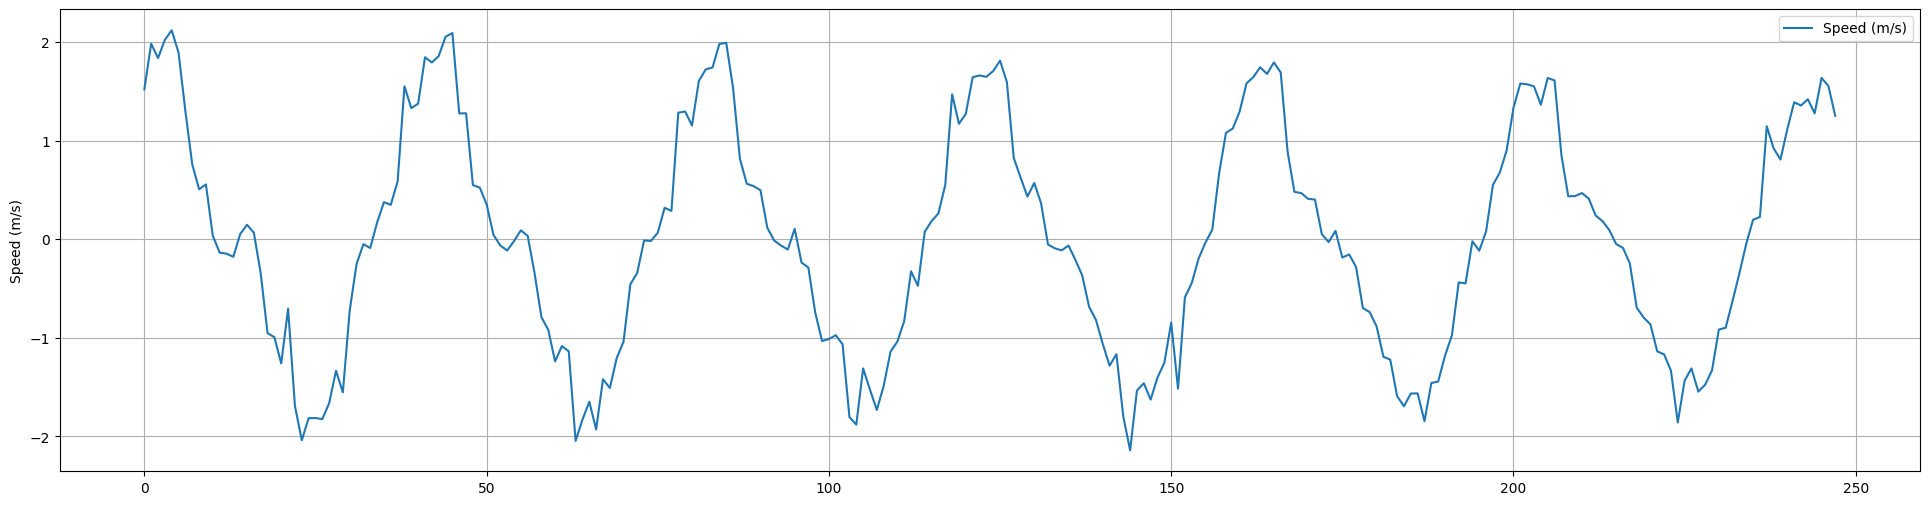

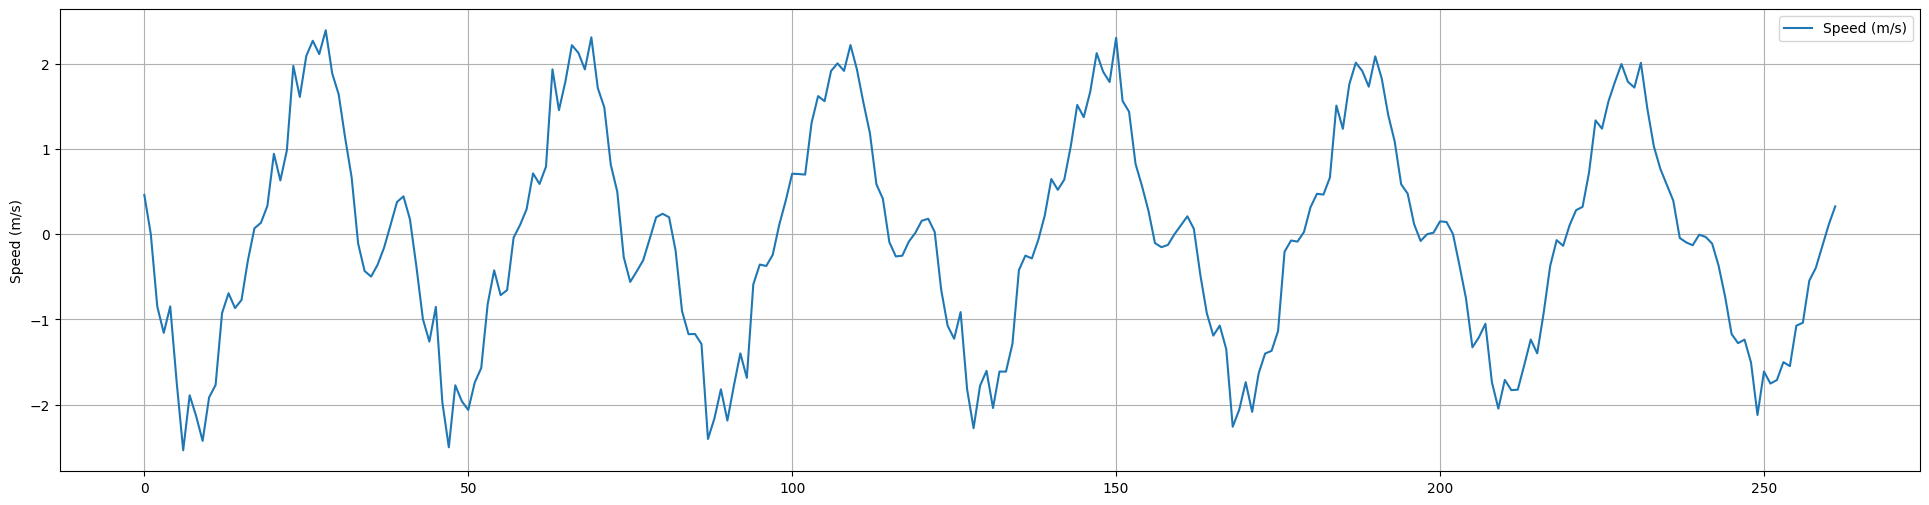

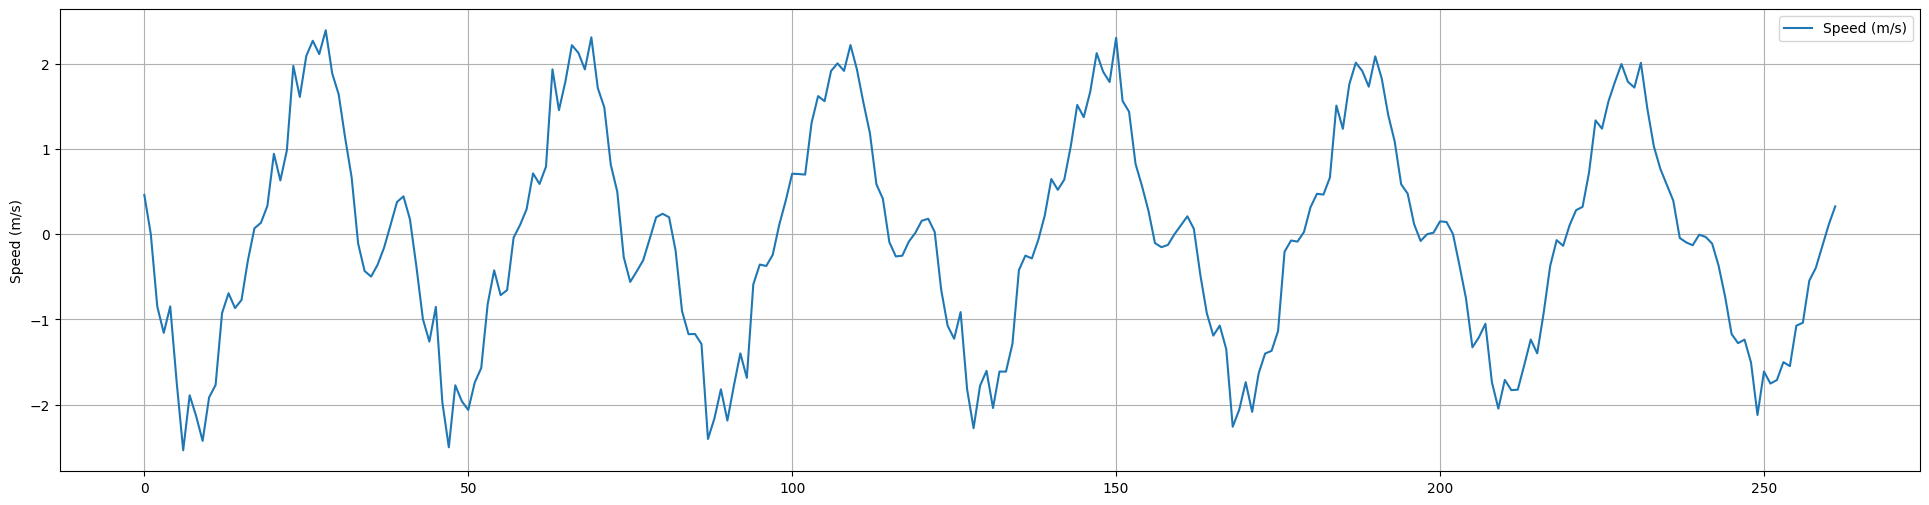

In [32]:
run_experimental_computation(FORTYFIVE_DEG_SAMPLES, WFS_FORTYFIVE_DEG, '45deg')

## 60

Unfortunately, the $60^o$ angle proved too difficult to collect data for as the large angle caused some problems in our setup.

## Objective
- 4 angles, 10 samples for each = 40 total
- For each sample, find 5 highest crests + 5 lowest troughs
- absolute value all points
- avg all points

## Graphing
- one overall velocity vs degree line graph
- graph for each item of trials, with line for expected value

In [34]:
results_df_setup = {
    'Angle': [5, 10, 15, 20, 25, 30, 35, 40, 45],
    'Avg. Velocity (m/s)': RESULTS,
    'Standard Deviation': STDEVS
}
master_results_df = pd.DataFrame(data=results_df_setup)
display(master_results_df)
plot_trial_dataframe(master_results_df, xlabel='Angle', ylabel='Avg. Velocity (m/s)', yerr=results_df_setup['Standard Deviation'])

ValueError: All arrays must be of the same length

## Reference links
- [pandas.DataFrame.plot — pandas 2.0.1 documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html)
- [matplotlib.pyplot.errorbar — Matplotlib 3.7.1 documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html#examples-using-matplotlib-pyplot-errorbar)
- [Errorbar limit selection — Matplotlib 3.7.1 documentation](https://matplotlib.org/stable/gallery/lines_bars_and_markers/errorbar_limits_simple.html#sphx-glr-gallery-lines-bars-and-markers-errorbar-limits-simple-py)